# Team name: Group 6
* Full name: Sverre Nystad, StudentNr: 56882,  Kandidatnr: 10003, Kaggle Name: Sverre Nystad
* Full name: Gunnar Nystad, StudentNr: 527760, Kandidatnr: 10344, Kaggle Name: Gunnar Nystad
* Full name: Peter Skoland, StudentNr: 528091, Kandidatnr 10307,  Kaggle Name: Peter Skoland

# Table of contents:
* Importing of external libraries 
* Importing of data
* Importing of own libraries
* Exploratory data analysis
* Exploratory Feature Engineering
* Exploratory PCA and CCA
* Different models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%pip install statsmodels
%pip install scikit-learn
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.ensemble import RandomForestRegressor

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


# Load raw data

In [2]:
PATH_RAW_DATA_LOCATION = "data/raw/"

def get_raw_data():
    """
    Utility function to load the raw data from the data/raw folder.

    Returns:
        train_a (pd.DataFrame): The training targets for the A dataset.
        train_b (pd.DataFrame): The training targets for the B dataset.
        train_c (pd.DataFrame): The training targets for the C dataset.
        X_train_estimated_a (pd.DataFrame): The estimated training features for the A dataset.
        X_train_estimated_b (pd.DataFrame): The estimated training features for the B dataset.
        X_train_estimated_c (pd.DataFrame): The estimated training features for the C dataset.
        X_train_observed_a (pd.DataFrame): The observed training features for the A dataset.
        X_train_observed_b (pd.DataFrame): The observed training features for the B dataset.
        X_train_observed_c (pd.DataFrame): The observed training features for the C dataset.
        X_test_estimated_a (pd.DataFrame): The estimated test features for the A dataset.
        X_test_estimated_b (pd.DataFrame): The estimated test features for the B dataset.
        X_test_estimated_c (pd.DataFrame): The estimated test features for the C dataset.
    """
    train_a = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}A/train_targets.parquet')
    train_b = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}B/train_targets.parquet')
    train_c = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}C/train_targets.parquet')
    X_train_estimated_a = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}A/X_train_estimated.parquet')
    X_train_estimated_b = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}B/X_train_estimated.parquet')
    X_train_estimated_c = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}C/X_train_estimated.parquet')
    X_train_observed_a = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}A/X_train_observed.parquet')
    X_train_observed_b = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}B/X_train_observed.parquet')
    X_train_observed_c = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}C/X_train_observed.parquet')
    X_test_estimated_a = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}A/X_test_estimated.parquet')
    X_test_estimated_b = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}B/X_test_estimated.parquet')
    X_test_estimated_c = pd.read_parquet(f'{PATH_RAW_DATA_LOCATION}C/X_test_estimated.parquet')

    return train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c



def get_all_features() -> list:
    """
    Utility function to get all features from the raw data.

    Returns:
        features (list): A list of all features.
    """
    _, _, _, X_train_estimated_a, _, _, _, _, _, _, _, _ = get_raw_data()
    print(X_train_estimated_a.keys())
    all_features = X_train_estimated_a.keys()[0]
    all_featues = [feature for feature in all_features if feature != 'date_forecast']
    return all_featues

def get_tests() -> pd.DataFrame:
    """
    Utility function to load the raw data from the data/raw folder.q
    """
    test = pd.read_csv(f'{PATH_RAW_DATA_LOCATION}test.csv')
    return test

def create_preprocessed_data():
    _, _, _, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, _, _, _ = get_raw_data()
    X_train_estimated_a = create_expected_pv_based_on_previous_years_same_day(X_train_estimated_a)
    X_train_estimated_b = create_expected_pv_based_on_previous_years_same_day(X_train_estimated_b)
    X_train_estimated_c = create_expected_pv_based_on_previous_years_same_day(X_train_estimated_c)
    X_train_observed_a = create_expected_pv_based_on_previous_years_same_day(X_train_observed_a)
    X_train_observed_b = create_expected_pv_based_on_previous_years_same_day(X_train_observed_b)
    X_train_observed_c = create_expected_pv_based_on_previous_years_same_day(X_train_observed_c)

def create_expected_pv_based_on_previous_years_same_day(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a mean pv_measurement for each data point based on the previous years same day and hour
    Add this as a feature to the data frame
    
    Parameters:
        df (pd.DataFrame): DataFrame containing at least columns: 
                           location_a, location_b, location_c, date_forecast, 
                           pv_measurement, sin_day_of_year, cos_day_of_year, sin_hour, cos_hour
    
    Returns:
        pd.DataFrame: DataFrame with additional feature of mean pv_measurement based on historical data
    """
    df = df.copy()
    
    # Identify the location from the binary flags
    df['location'] = df[['location_a', 'location_b', 'location_c']].idxmax(axis=1)
    
    # Calculate mean pv_measurement for each location, sin_day_of_year, cos_day_of_year, sin_hour, and cos_hour
    mean_pv = df.groupby(['location', 'sin_day_of_year', 'cos_day_of_year', 'sin_hour', 'cos_hour'])['pv_measurement'].mean().reset_index()
    mean_pv.rename(columns={'pv_measurement': 'mean_pv_measurement'}, inplace=True)
    
    # Merge mean_pv_measurement back to the original DataFrame
    df = pd.merge(df, mean_pv, on=['location', 'sin_day_of_year', 'cos_day_of_year', 'sin_hour', 'cos_hour'], how='left')
    df.drop(columns=['location'], inplace=True)
    return df
if __name__ == "__main__":
    data = get_raw_data()
    print(data[0].head())


                 time  pv_measurement
0 2019-06-02 22:00:00            0.00
1 2019-06-02 23:00:00            0.00
2 2019-06-03 00:00:00            0.00
3 2019-06-03 01:00:00            0.00
4 2019-06-03 02:00:00           19.36


# Feature engineering Library

In [3]:
from datetime import datetime
import pandas as pd
from typing import List, Tuple
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import math


def prepare_data(
    train_observed: pd.DataFrame,
    train_estimated: pd.DataFrame,
    test_size=0.2,
    random_state=42,
    drop_features: bool = True,
) -> Tuple[
    pd.DataFrame,
    pd.DataFrame,
    pd.Series,
    pd.Series,
    pd.DataFrame,
    pd.DataFrame,
    pd.Series,
    pd.Series,
]:
    """
    Prepares the data for modeling by handling missing values and splitting the data.

    Args:
    train_observed (pd.DataFrame): The aligned training DataFrame with observed features.
    train_estimated (pd.DataFrame): The aligned training DataFrame with estimated features.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
    X_train_obs (pd.DataFrame): The training features with observed data.
    X_val_obs (pd.DataFrame): The validation features with observed data.
    y_train_obs (pd.Series): The training target with observed data.
    y_val_obs (pd.Series): The validation target with observed data.
    X_train_est (pd.DataFrame): The training features with estimated data.
    X_val_est (pd.DataFrame): The validation features with estimated data.
    y_train_est (pd.Series): The training target with estimated data.
    y_val_est (pd.Series): The validation target with estimated data.
    """

    # Remove missing features
    train_observed = remove_missing_features(train_observed)
    train_estimated = remove_missing_features(train_estimated)

    # Handle missing values (e.g., imputation, removal)
    train_observed_clean = train_observed.dropna(
        subset=["visibility:m", "pv_measurement"]
    )
    train_estimated_clean = train_estimated.dropna(
        subset=["visibility:m", "pv_measurement"]
    )

    # Remove discrepancies
    train_observed_clean = clean_pv_data(train_observed_clean)
    train_estimated_clean = clean_pv_data(train_estimated_clean)

    # Feature engineer
    train_observed_clean = feature_engineer(train_observed_clean)
    train_estimated_clean = feature_engineer(train_estimated_clean)

    # Split the data into features (X) and target (y)

    y_obs = train_observed_clean["pv_measurement"]

    if drop_features:
        X_obs = train_observed_clean.drop(
            columns=["time", "pv_measurement", "date_forecast", "date_calc"],
            errors="ignore",
        )
    else:
        X_obs = train_observed_clean

    if drop_features:
        X_est = train_estimated_clean.drop(
            columns=["time", "pv_measurement", "date_calc", "date_forecast"],
            errors="ignore",
        )
    else:
        X_est = train_estimated_clean

    y_est = train_estimated_clean["pv_measurement"]

    # Split the data into training and validation sets
    X_train_obs, X_val_obs, y_train_obs, y_val_obs = train_test_split(
        X_obs, y_obs, test_size=test_size, random_state=random_state
    )
    X_train_est, X_val_est, y_train_est, y_val_est = train_test_split(
        X_est, y_est, test_size=test_size, random_state=random_state
    )

    return (
        X_train_obs,
        X_val_obs,
        y_train_obs,
        y_val_obs,
        X_train_est,
        X_val_est,
        y_train_est,
        y_val_est,
    )


def get_location_datasets(
    df: pd.DataFrame,
) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    locations = ["location_a", "location_b", "location_c"]
    x_a = df[df["location_a"] == 1]
    x_a = x_a.drop(locations, axis=1)
    y_a = x_a["pv_measurement"]
    if "pv_measurement" in x_a.columns:
        x_a = x_a.drop("pv_measurement", axis=1)

    x_b = df[df["location_b"] == 1]
    x_b = x_b.drop(locations, axis=1)
    y_b = x_b["pv_measurement"]
    if "pv_measurement" in x_b.columns:
        x_b = x_b.drop("pv_measurement", axis=1)

    x_c = df[df["location_c"] == 1]
    x_c = x_c.drop(locations, axis=1)
    y_c = x_c["pv_measurement"]
    if "pv_measurement" in x_b.columns:
        x_b = x_b.drop("pv_measurement", axis=1)

    return (x_a, x_b, x_c, y_a, y_b, y_c)


def remove_missing_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop("snow_density:kgm3", axis=1)
    df = df.drop("ceiling_height_agl:m", axis=1)
    df["cloud_base_agl:m"] = df["cloud_base_agl:m"].fillna(0)
    df = df.drop("elevation:m", axis=1)
    return df


def clean_pv_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply a series of filters to clean PV data in the DataFrame.

    Args:
    df (pd.DataFrame): DataFrame containing PV measurement data.

    Returns:
    pd.DataFrame: Cleaned DataFrame after applying all filters.
    """
    df = filter_pv_measurements_at_night(df)
    df = filter_constant_pv_measurements(df)
    df = filter_zero_pv_measurements(df)
    return df


def filter_pv_measurements_at_night(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter out positive PV measurements at night based on specific conditions. As there are no PV measurements at night, these are likely to be measurement errors.

    Args:
    df (pd.DataFrame): DataFrame containing PV measurement and time-of-day data.

    Returns:
    pd.DataFrame: DataFrame with unrealistic positive PV measurements at night removed.
    """
    
    # Condition: Positive PV measurement when it's not daytime and the measurement is the same as the previous timestep
    night_time_with_positive_pv = (df["is_day:idx"] == 0) & (df["pv_measurement"] > 0)
    same_as_previous_step = df["pv_measurement"] == df["pv_measurement"].shift(1)
    condition1 = night_time_with_positive_pv & same_as_previous_step

    # Condition: Positive PV measurement when sun elevation is below a certain threshold
    sun_elevation_threshold = -10
    low_sun_elevation_with_positive_pv = (df["sun_elevation:d"] < sun_elevation_threshold) & (df["pv_measurement"] > 0)
    
    # Combined condition to filter
    conditions_to_remove = condition1 | low_sun_elevation_with_positive_pv
    df = df.drop(df[conditions_to_remove].index)

    return df


def filter_constant_pv_measurements(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter out rows where PV measurement is constant and non-zero for 6 or more consecutive timesteps.

    Args:
    df (pd.DataFrame): DataFrame containing PV measurement data.

    Returns:
    pd.DataFrame: DataFrame with specified discrepancies removed.
    """
    
    # Step 1: Mark changes in pv_measurement and zero values
    measurement_change_or_zero = (df["pv_measurement"] != df["pv_measurement"].shift()) | (df["pv_measurement"] == 0)
    
    # Step 2: Create groups for consecutive measurements
    df["temp_group"] = measurement_change_or_zero.cumsum()

    # Step 3: Count entries in each group
    group_counts = df.groupby("temp_group")["pv_measurement"].transform("count")

    # Step 4: Determine rows to remove (constant non-zero measurements for 6+ timesteps)
    rows_to_remove = (group_counts >= 6) & (df["pv_measurement"] != 0)

    # Step 5: Remove specified rows and the temporary grouping column
    df_filtered = df[~rows_to_remove].drop(columns=["temp_group"])
    
    return df_filtered



def filter_zero_pv_measurements(
    un_filtered_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    Remove entries where PV measurements are zero despite significant radiation.

    Args:
    df (pd.DataFrame): DataFrame containing radiation and PV measurement data.

    Returns:
    pd.DataFrame: Filtered DataFrame.
    """
    # Trail and error on total_radiation_threshold, tried 0.5, 5 and 30
    total_radiation_threshold = 30
    is_significant_radiation = (un_filtered_df["diffuse_rad:W"] + un_filtered_df["direct_rad:W"]) >= total_radiation_threshold
    is_zero_pv_measurement = un_filtered_df["pv_measurement"] == 0
    filtered_df = un_filtered_df[~(is_significant_radiation & is_zero_pv_measurement)]
    return filtered_df



def remove_outliers(
    df: pd.DataFrame, lower_bound: float = 0.1, upper_bound: float = 0.9
) -> pd.DataFrame:
    """
    Removing outliers using IQR method
    """

    columns_to_check = [col for col in df.columns if col != "pv_measurement"]
    for col in columns_to_check:
        # Calculate IQR
        Q1 = df[col].quantile(lower_bound)
        Q3 = df[col].quantile(upper_bound)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter the data
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df



def feature_engineer(data_frame: pd.DataFrame) -> pd.DataFrame:
    data_frame = create_time_features_from_date(data_frame)
    # data_frame = create_expected_pv_based_on_previous_years_same_day(data_frame)
    data_frame["solar_radiation_interaction"] = data_frame["diffuse_rad:W"] * data_frame["direct_rad:W"]

    data_frame["effective_solar_elevation"] = np.where(
        data_frame["sun_elevation:d"] <= 0,
        0,
        np.sin(np.radians(data_frame["sun_elevation:d"])),
    )
    data_frame = data_frame.drop("sun_elevation:d", axis=1)

    data_frame["effective_radiation"] = np.where(
        data_frame["clear_sky_energy_1h:J"] == 0,
        0,  # or your specified value
        data_frame["direct_rad_1h:J"] / data_frame["clear_sky_energy_1h:J"],
    )

    # Check for the existence of date_calc column
    if "date_calc" not in data_frame.columns:
        data_frame["time_since_prediction"] = 0
    else:
        data_frame["time_since_prediction"] = 1

    # data_frame["time_since_prediction"] =

    data_frame["net_clear_sky_residual"] = (
        data_frame["clear_sky_rad:W"]
        - data_frame["direct_rad:W"]
        - data_frame["diffuse_rad:W"]
    )

    # WAS WORSE
    # data_frame["effective_radiation2"] = np.where(
    #     data_frame["clear_sky_rad:W"] == 0,
    #     0,  # or your specified value
    #     data_frame["direct_rad:W"] / data_frame["clear_sky_rad:W"],
    # )

    data_frame["cloud_ratio"] = np.where(
        data_frame["total_cloud_cover:p"] == 0,
        0,  # or your specified value
        data_frame["effective_cloud_cover:p"] / data_frame["total_cloud_cover:p"],
    )

    data_frame["low_cloud_diffuse_rad"] = data_frame[
        "diffuse_rad:W"
    ].where(data_frame["effective_cloud_cover:p"] < 0.3, 0)

    data_frame["cloud_cover_over_30%"] = np.where(
        data_frame["effective_cloud_cover:p"] > 30, 1, 0
    )

    data_frame["global_horizon_index"] = (
        data_frame["diffuse_rad:W"] + data_frame["direct_rad:W"]
    )

    data_frame["direct_rad_cloud_interaction"] = data_frame["direct_rad:W"] * (
        100 - data_frame["effective_cloud_cover:p"]
    )

    data_frame["effective_solar_elevation_squared"] = (
        data_frame["effective_solar_elevation"] ** 0.5
    )
    
    # data_frame["global_horizon_index_squared"] = data_frame["global_horizon_index"] ** 2

    snow_columns = [
        "snow_depth:cm",
        "fresh_snow_12h:cm",
        "fresh_snow_1h:cm",
        "fresh_snow_24h:cm",
        "fresh_snow_3h:cm",
        "fresh_snow_6h:cm",
    ]

    # Was worse
    # data_frame["surface_temperature"] = data_frame.apply(calculate_surface_temp, axis=1)
    # data_frame["50m_temperature"] = data_frame.apply(calculate_50m_temp, axis=1)
    # data_frame["100m_temperature"] = data_frame.apply(calculate_100m_temp, axis=1)
    # data_frame = data_frame.drop("t_1000hPa:K", axis=1)

    # data_frame["global_horizon_index"] = (
    #     data_frame["direct_rad_1h:J"] + data_frame["diffuse_rad_1h:J"]
    # )

    # Create a feature that is precip_5min:mm * precip_type_5min.idx
    # data_frame["any_precip"] = (
    #     data_frame["precip_5min:mm"] * data_frame["precip_type_5min:idx"]
    # )

    # data_frame["sun addition W to 1h ratio"] = (
    #     data_frame["global_horizon_index"]
    #     * 3600
    #     / (data_frame["direct_rad_1h:J"] + data_frame["diffuse_rad_1h:J"])
    # ).fillna(1)

    # data_frame["rime"] = data_frame["prob_rime:p"].apply(lambda x: 1 if x > 0 else 0)
    # data_frame = data_frame.drop("prob_rime:p", axis=1)

    data_frame["is_freezing"] = (data_frame["t_1000hPa:K"] < 273).astype(int)

    data_frame["is_snow"] = (data_frame[snow_columns] > 0).any(axis=1).astype(int)
    data_frame["is_rain"] = (data_frame["precip_5min:mm"] > 0).astype(int)

    data_frame = data_frame.drop("snow_drift:idx", axis=1)
    # Was worse
    # data_frame = data_frame.drop("snow_depth:cm", axis=1)
    # data_frame = data_frame.drop("snow_water:kgm2", axis=1)
    # data_frame = data_frame.drop("fresh_snow_12h:cm", axis=1)
    # data_frame = data_frame.drop("fresh_snow_1h:cm", axis=1)
    # data_frame = data_frame.drop("fresh_snow_24h:cm", axis=1)
    # data_frame = data_frame.drop("fresh_snow_3h:cm", axis=1)
    # data_frame = data_frame.drop("fresh_snow_6h:cm", axis=1)
    # data_frame = data_frame.drop("snow_melt_10min:mm", axis=1)

    # data_frame = data_frame.drop("msl_pressure:hPa", axis=1)
    # data_frame = data_frame.drop("pressure_100m:hPa", axis=1)
    # data_frame = data_frame.drop("sfc_pressure:hPa", axis=1)

    # Add maximum pv_measurement based on location
    # max_pv_a = 5733.42
    # max_pv_b = 1152.3
    # max_pv_c = 999.6
    # data_frame["max_pv_location"] = np.where(
    #     data_frame["location_a"] == 1,
    #     max_pv_a,
    #     np.where(
    #         data_frame["location_b"] == 1,
    #         max_pv_b,
    #         np.where(data_frame["location_c"] == 1, max_pv_c, np.nan),
    #     ),
    # )

    # # Add average pv_measurement based on location
    # average_pv_a = 814.88
    # average_pv_b = 129.375
    # average_pv_c = 117.6
    # data_frame["average_pv_location"] = np.where(
    #     data_frame["location_a"] == 1,
    #     average_pv_a,
    #     np.where(
    #         data_frame["location_b"] == 1,
    #         average_pv_b,
    #         np.where(data_frame["location_c"] == 1, average_pv_c, np.nan),
    #     ),
    # )

    # # Add Maximum_pv_location times global_horizon_index
    # data_frame["max_pv_location_times_global_horizon_index"] = (
    #     data_frame["max_pv_location"] * data_frame["global_horizon_index"]
    # )

    # # Add Maximum_pv_location times global_horizon_index
    # data_frame["average_pv_location_times_global_horizon_index"] = (
    #     data_frame["average_pv_location"] * data_frame["global_horizon_index"]
    # )

    # data_frame["global_horizon_index_temp_ratio"] = (
    #     data_frame["max_pv_location"]
    #     * data_frame["global_horizon_index"]
    #     / data_frame["t_1000hPa:K"]
    # )

    return data_frame


def ratio(df: pd.DataFrame) -> pd.DataFrame:
    import pandas as pd
    from sklearn.linear_model import LinearRegression

    # Sample DataFrame (replace this with your actual DataFrame)

    # Calculate total irradiance
    df["total_radiance"] = df["direct_radiance"] + df["diffuse_radiance"]

    # Set up the linear regression problem
    X = df[["total_radiance", "ambient_temp"]]
    y = df["pv_measurement"]

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Extract coefficients
    a = model.coef_[0]  # Coefficient for total_radiance
    b = model.coef_[1]  # Coefficient for ambient_temp
    c = model.intercept_

    # Estimate the parameters
    T_ref = 25  # Reference temperature, you can set this based on your understanding
    eta = a  # Assuming that a corresponds to efficiency
    beta = (
        -b / a
    )  # Assuming linear relationship between power drop and temperature increase

    # Estimate panel temperature
    df["T_panel"] = df["ambient_temp"] + (df["total_radiance"] / a) * (1 - eta)

    # Calculate the desired ratio
    df["ratio"] = 1 - beta * (df["T_panel"] - T_ref)

    # Display the DataFrame
    return df


def calculate_surface_temp(row):
    # Constants
    R = 287  # Specific gas constant for dry air, J kg^-1 K^-1
    g = 9.81  # Acceleration due to gravity, m s^-2
    lapse_rate = 0.0065  # Average lapse rate, K m^-1

    P1 = 1000  # Initial pressure level, hPa
    P2 = row["sfc_pressure:hPa"]  # Final pressure level, hPa
    T1 = row["t_1000hPa:K"]  # Temperature at P1, K

    # Altitude difference using barometric formula (approximation)
    delta_h = (R * T1 / g) * np.log(P1 / P2)

    # Temperature difference using constant lapse rate
    delta_T = lapse_rate * delta_h

    # Temperature at P2, converting from K to C
    T2_C = T1 - delta_T - 273.15

    return T2_C


def calculate_50m_temp(row):
    # Constants
    R = 287  # Specific gas constant for dry air, J kg^-1 K^-1
    g = 9.81  # Acceleration due to gravity, m s^-2
    lapse_rate = 0.0065  # Average lapse rate, K m^-1

    P1 = 1000  # Initial pressure level, hPa
    P2 = row["pressure_50m:hPa"]  # Final pressure level, hPa
    T1 = row["t_1000hPa:K"]  # Temperature at P1, K

    # Altitude difference using barometric formula (approximation)
    delta_h = (R * T1 / g) * np.log(P1 / P2)

    # Temperature difference using constant lapse rate
    delta_T = lapse_rate * delta_h

    # Temperature at P2, converting from K to C
    T2_C = T1 - delta_T - 273.15

    return T2_C


def calculate_100m_temp(row):
    # Constants
    R = 287  # Specific gas constant for dry air, J kg^-1 K^-1
    g = 9.81  # Acceleration due to gravity, m s^-2
    lapse_rate = 0.0065  # Average lapse rate, K m^-1

    P1 = 1000  # Initial pressure level, hPa
    P2 = row["pressure_100m:hPa"]  # Final pressure level, hPa
    T1 = row["t_1000hPa:K"]  # Temperature at P1, K

    # Altitude difference using barometric formula (approximation)
    delta_h = (R * T1 / g) * np.log(P1 / P2)

    # Temperature difference using constant lapse rate
    delta_T = lapse_rate * delta_h

    # Temperature at P2, converting from K to C
    T2_C = T1 - delta_T - 273.15

    return T2_C


def create_time_features_from_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new data frame with new features from date_forecast column.
    This will create temporal features from date_forecast that are easier to learn by the model.
    It creates the following features: month, season, year, day_of_year, day_segment.
    All of the new features are int type.

    Args:
        df (pd.DataFrame): Data frame with date_forecast column.
    Returns:
        pd.DataFrame: Data frame copy with new features.

    """
    df["sin_day_of_year"] = df["date_forecast"].apply(get_sin_day)
    df["cos_day_of_year"] = df["date_forecast"].apply(get_cos_day)
    df["sin_hour"] = df["date_forecast"].apply(get_sin_hour)
    df["cos_hour"] = df["date_forecast"].apply(get_cos_hour)
    return df



def get_sin_hour(date: datetime) -> float:
    HOURS_OF_DAY = 24
    return math.sin(2 * math.pi * (date.hour) / HOURS_OF_DAY)


def get_cos_hour(date: datetime) -> float:
    HOURS_OF_DAY = 24
    return math.cos(2 * math.pi * (date.hour) / HOURS_OF_DAY)


def get_sin_day(date: datetime) -> float:
    DAY_OF_YEAR = 365.25  # Add 0.25 to account for leap years
    return math.sin(2 * math.pi * (date.timetuple().tm_yday - 1) / DAY_OF_YEAR)


def get_cos_day(date: datetime) -> float:
    DAY_OF_YEAR = 365.25  # Add 0.25 to account for leap years

    return math.cos(2 * math.pi * (date.timetuple().tm_yday - 1) / DAY_OF_YEAR)


def create_polynomial_features(
    df, columns, degree=2, include_bias=False, interaction_only=False
):
    """
    Create polynomial features for specified columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list): List of column names for which to create polynomial features.
    - degree (int): The degree of the polynomial features. Default is 2.
    - include_bias (bool): Whether to include a bias column in the output. Default is False.
    - interaction_only (bool): Whether to include only interaction features. Default is False.

    Returns:
    - df_poly (pd.DataFrame): DataFrame with original and new polynomial features.
    """
    poly = PolynomialFeatures(
        degree=degree, include_bias=include_bias, interaction_only=interaction_only
    )
    poly_features = poly.fit_transform(df[columns])
    feature_names = poly.get_feature_names(input_features=columns)

    df_poly = pd.DataFrame(poly_features, columns=feature_names, index=df.index)
    df_poly = df_poly.drop(
        columns=columns
    )  # Drop original columns as they are included in the polynomial features

    # Concatenate the original DataFrame with the new polynomial features DataFrame
    df_poly = pd.concat([df.drop(columns=columns), df_poly], axis=1)

    return df_poly


def log_transform(df: pd.DataFrame, columns: List[str]):
    df_transformed = df.copy()
    for column in columns:
        df_transformed[column] = np.log1p(df_transformed[column])
    return df_transformed


def scale_features(df: pd.DataFrame, columns: List[str], method="standard"):
    df_scaled = df.copy()
    scaler = StandardScaler() if method == "standard" else MinMaxScaler()
    df_scaled[columns] = scaler.fit_transform(df_scaled[columns])
    return df_scaled


def trig_transform(df: pd.DataFrame, column: str, period: int):
    df_trig = df.copy()
    df_trig[f"{column}_sin"] = np.sin(2 * math.pi * df_trig[column] / period)
    df_trig[f"{column}_cos"] = np.cos(2 * math.pi * df_trig[column] / period)
    return df_trig


def create_expected_pv_based_on_previous_years_same_day(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """
    Create a mean pv_measurement for each data point based on the previous years same day and hour
    Add this as a feature to the data frame

    Parameters:
        df (pd.DataFrame): DataFrame containing at least columns:
                           location_a, location_b, location_c, date_forecast,
                           pv_measurement, sin_day_of_year, cos_day_of_year, sin_hour, cos_hour

    Returns:
        pd.DataFrame: DataFrame with additional feature of mean pv_measurement based on historical data
    """
    df = df.copy()
    # When the data does not contain needed columns, return the original df.
    if not all(
        col in df.columns
        for col in [
            "location_a",
            "location_b",
            "location_c",
            "pv_measurement",
            "sin_day_of_year",
            "cos_day_of_year",
            "sin_hour",
            "cos_hour",
        ]
    ):
        return df
    # Identify the location from the binary flags
    df["location"] = df[["location_a", "location_b", "location_c"]].idxmax(axis=1)

    # Calculate mean pv_measurement for each location, sin_day_of_year, cos_day_of_year, sin_hour, and cos_hour
    mean_pv = (
        df.groupby(
            ["location", "sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"]
        )["pv_measurement"]
        .mean()
        .reset_index()
    )
    mean_pv.rename(columns={"pv_measurement": "mean_pv_measurement"}, inplace=True)

    # Merge mean_pv_measurement back to the original DataFrame
    df = pd.merge(
        df,
        mean_pv,
        on=["location", "sin_day_of_year", "cos_day_of_year", "sin_hour", "cos_hour"],
        how="left",
    )
    df.drop(columns=["location"], inplace=True)
    return df


def create_simple_rolling_mean(
    df: pd.DataFrame, column: str, window: int
) -> pd.DataFrame:
    """
    Creates a simple rolling mean feature for a given column in a DataFrame.

    Args:
        df: DataFrame containing your time-series data.
        column: The name of the column for which you want to create lagged features.
        window: The size of the window for calculating the rolling mean.
                For example, if window=10, it will take the previous 10 days.
    """
    # Ensure the DataFrame is sorted by date
    df = df.sort_values(by="date_forecast")

    # Ensure 'date_forecast' is in datetime format
    df["date_forecast"] = pd.to_datetime(df["date_forecast"])

    # Calculate the rolling mean
    df["rolling_mean_of_" + column] = df[column].rolling(window=window).mean()

    return df


# Define a function to identify positively skewed numerical features in a DataFrame
def identify_skewed_features(df, skew_threshold=1):
    # Select numerical features
    num_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()

    # Calculate skewness for each numerical feature and filter those that are positively skewed
    skewed_features = [
        feature for feature in num_features if skew(df[feature]) > skew_threshold
    ]

    return skewed_features


def create_domain_specific_features(df):
    """
    Create domain-specific features for solar energy production.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - df_domain (pd.DataFrame): DataFrame with original and new domain-specific features.
    """
    df_domain = df.copy()

    # Create a binary feature representing whether the sky is clear
    df_domain["is_clear_sky"] = (df_domain["clear_sky_energy_1h:J"] > 0).astype(int)

    # Create a feature representing total sun exposure
    df_domain["total_sun_exposure"] = (
        df_domain["direct_rad:W"] + df_domain["diffuse_rad:W"]
    )

    # Create a binary feature representing whether it is raining
    df_domain["is_raining"] = (df_domain["precip_5min:mm"] > 0).astype(int)

    # Create a binary feature representing whether there is snow cover
    df_domain["is_snow_cover"] = (df_domain["snow_depth:cm"] > 0).astype(int)

    return df_domain


def clean_data(data_frame: pd.DataFrame) -> pd.DataFrame:
    """
    Clean data frame by removing outliers and NaN values.

    Args:
        df (pd.DataFrame): Data frame with date_forecast column.
    Returns:
        pd.DataFrame: Data frame copy without outliers and NaN values.

    """
    df = data_frame.copy()
    df = create_time_features_from_date(df)
    df = df[df["target"] > 0]
    return df


def add_location(data_frame: pd.DataFrame, location: str):
    if location.lower() == "a":
        data_frame["location_a"] = 1
    else:
        data_frame["location_a"] = 0

    if location.lower() == "b":
        data_frame["location_b"] = 1
    else:
        data_frame["location_b"] = 0

    if location.lower() == "c":
        data_frame["location_c"] = 1
    else:
        data_frame["location_c"] = 0
    return data_frame


# Define a function to align the temporal resolution of the datasets
def temporal_alignment(
    train: pd.DataFrame, observed: pd.DataFrame, estimated: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Aligns the temporal resolution of the datasets by aggregating the 15-min interval weather data to hourly intervals.

    Args:
        train (pd.DataFrame): The training targets DataFrame.
        observed (pd.DataFrame): The observed training features DataFrame.
        estimated (pd.DataFrame): The estimated training features DataFrame.

    Returns:
        train_observed (pd.DataFrame): The aligned training DataFrame with observed features.
        train_estimated (pd.DataFrame): The aligned training DataFrame with estimated features.
    """
    # Convert the time columns to datetime objects
    train["time"] = pd.to_datetime(train["time"])
    observed["date_forecast"] = pd.to_datetime(observed["date_forecast"])
    estimated["date_forecast"] = pd.to_datetime(estimated["date_forecast"])

    # Set the date_forecast column as index for resampling
    observed.set_index("date_forecast", inplace=True)
    estimated.set_index("date_forecast", inplace=True)

    # Resample the weather data to hourly intervals and aggregate the values by mean
    observed_resampled = observed.resample("1H").mean()
    estimated_resampled = estimated.resample("1H").mean()

    # Reset the index after resampling
    observed_resampled.reset_index(inplace=True)
    estimated_resampled.reset_index(inplace=True)

    # Merge the aggregated weather data with the solar production data based on the timestamp
    train_observed = pd.merge(
        train, observed_resampled, how="left", left_on="time", right_on="date_forecast"
    )
    train_estimated = pd.merge(
        train, estimated_resampled, how="left", left_on="time", right_on="date_forecast"
    )

    return train_observed, train_estimated


def temporal_alignment_tests(test: pd.DataFrame) -> Tuple[pd.DataFrame]:
    return aggregate_rows(test)


def aggregate_rows(df: pd.DataFrame) -> pd.DataFrame:
    # Create a 'group' column to group every 4 rows together
    df["group"] = df.index // 4

    # Define the aggregation functions
    aggregation = {col: "mean" for col in df.columns if col != "date_forecast"}
    aggregation["date_forecast"] = "first"

    # Group by the 'group' column and aggregate
    df_agg = df.groupby("group").agg(aggregation).reset_index(drop=True)

    # Drop the 'group' column from the original dataframe
    df_agg.drop("group", axis=1, inplace=True)

    return df_agg


# Preprocessing library

In [4]:
from typing import Tuple
import pandas as pd


def fetch_preprocessed_data(drop_features: bool = True) -> (
    Tuple[
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
        pd.DataFrame,
    ]
):
    """
    Fetch the preprocessed data for training and validation.

    Returns:
        X_train_obs_combined: The observed data for training
        X_val_obs_combined: The observed data for validation
        y_train_obs_combined: The observed labels for training
        y_val_obs_combined: The observed labels for validation
        X_train_est_combined: The estimated data for training
        X_val_est_combined: The estimated data for validation
        y_train_est_combined: The estimated labels for training
        y_val_est_combined: The estimated labels for validation
    """
    (
        train_a,
        train_b,
        train_c,
        X_train_estimated_a,
        X_train_estimated_b,
        X_train_estimated_c,
        X_train_observed_a,
        X_train_observed_b,
        X_train_observed_c,
        _,
        _,
        _,
    ) = get_raw_data()

    # Temporally align the data from all three locations to the same time.
    train_observed_a, train_estimated_a = temporal_alignment(
        train_a, X_train_observed_a, X_train_estimated_a
    )
    train_observed_b, train_estimated_b = temporal_alignment(
        train_b, X_train_observed_b, X_train_estimated_b
    )
    train_observed_c, train_estimated_c = temporal_alignment(
        train_c, X_train_observed_c, X_train_estimated_c
    )

    # Add location data
    train_observed_a = add_location(train_observed_a, "a")
    train_estimated_a = add_location(train_estimated_a, "a")

    train_observed_b = add_location(train_observed_b, "b")
    train_estimated_b = add_location(train_estimated_b, "b")

    train_observed_c = add_location(train_observed_c, "c")
    train_estimated_c = add_location(train_estimated_c, "c")

    # Combine the temporally aligned datasets from all three locations
    train_observed_combined = pd.concat(
        [train_observed_a, train_observed_b, train_observed_c], ignore_index=True
    )
    train_estimated_combined = pd.concat(
        [train_estimated_a, train_estimated_b, train_estimated_c], ignore_index=True
    )

    # Prepare the combined dataset by handling missing values and splitting the data
    (
        X_train_obs_combined,
        X_val_obs_combined,
        y_train_obs_combined,
        y_val_obs_combined,
        X_train_est_combined,
        X_val_est_combined,
        y_train_est_combined,
        y_val_est_combined,
    ) = prepare_data(train_observed_combined, train_estimated_combined, drop_features=drop_features)

    return (
        X_train_obs_combined,
        X_val_obs_combined,
        y_train_obs_combined,
        y_val_obs_combined,
        X_train_est_combined,
        X_val_est_combined,
        y_train_est_combined,
        y_val_est_combined,
    )

def get_preprocessed_test_data() -> pd.DataFrame:
    """
    Get the preprocessed test data without the 'date_forecast' column.
    """
    (
        _,
        _,
        _,
        _,
        _,
        _,
        _,
        _,
        _,
        X_test_estimated_a,
        X_test_estimated_b,
        X_test_estimated_c,
    ) = get_raw_data()

    # Align the test data to the same time as the training data
    X_test_estimated_a = temporal_alignment_tests(X_test_estimated_a)
    X_test_estimated_b = temporal_alignment_tests(X_test_estimated_b)
    X_test_estimated_c = temporal_alignment_tests(X_test_estimated_c)
    print("After temporal alignment")
    print(f"X_test_estimated_a.shape = {X_test_estimated_a.shape}, X_test_estimated_b.shape = {X_test_estimated_b.shape}, X_test_estimated_c.shape = {X_test_estimated_c.shape}")

    X_test_estimated_a = remove_missing_features(X_test_estimated_a)
    X_test_estimated_b = remove_missing_features(X_test_estimated_b)
    X_test_estimated_c = remove_missing_features(X_test_estimated_c)

    # Add location data
    X_test_estimated_a = add_location(X_test_estimated_a, "a")
    X_test_estimated_b = add_location(X_test_estimated_b, "b")
    X_test_estimated_c = add_location(X_test_estimated_c, "c")

    X_test_a_correct_features = feature_engineer(X_test_estimated_a)
    X_test_b_correct_features = feature_engineer(X_test_estimated_b)
    X_test_c_correct_features = feature_engineer(X_test_estimated_c)

    # X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
    
    # # Add historical data so that the model can use it for prediction
    # # Add mean_pv_measurement with same day and hour from previous years
    # X_test_estimated_a_with_historical_data = add_expected_pv_to_test_data(X_test_a_correct_features, X_train_obs_combined)
    # X_test_estimated_b_with_historical_data = add_expected_pv_to_test_data(X_test_b_correct_features, X_train_obs_combined)
    # X_test_estimated_c_with_historical_data = add_expected_pv_to_test_data(X_test_c_correct_features, X_train_obs_combined)

    # Drop the 'date_calc' and 'date_forecast' columns from the test data
    X_test_estimated_a_processed = X_test_a_correct_features.drop(
        columns=["date_calc", "date_forecast"], errors='ignore'
    )
    X_test_estimated_b_processed = X_test_b_correct_features.drop(
        columns=["date_calc", "date_forecast"], errors='ignore'
    )
    X_test_estimated_c_processed = X_test_c_correct_features.drop(
        columns=["date_calc", "date_forecast"], errors='ignore'
    )

    # # # Handle NaN values in the test data by filling them with the mean value of the respective column from the training data
    # X_test_estimated_a_processed.dropna()
    # X_test_estimated_b_processed.dropna()
    # X_test_estimated_c_processed.dropna()
    print(f"X_test_estimated_a_processed.shape = {X_test_estimated_a_processed.shape}, X_test_estimated_b_processed.shape = {X_test_estimated_b_processed.shape}, X_test_estimated_c_processed.shape = {X_test_estimated_c_processed.shape}")
    tests = pd.concat([X_test_estimated_a_processed, X_test_estimated_b_processed, X_test_estimated_c_processed], ignore_index=True)
    return tests


# Our Plotting libriary

In [5]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import pywt

import os
# Create the directories for the figures
if not os.path.exists('results/figures'):
    os.makedirs('results/figures')
if not os.path.exists('results/figures/time_plot'):
    os.makedirs('results/figures/time_plot')
if not os.path.exists('results/figures/scatter_plot'):
    os.makedirs('results/figures/scatter_plot')
if not os.path.exists('results/figures/moving_average'):
    os.makedirs('results/figures/moving_average')
if not os.path.exists('results/figures/seasonal_trends'):
    os.makedirs('results/figures/seasonal_trends')
if not os.path.exists('results/figures/spectral_analysis'):
    os.makedirs('results/figures/spectral_analysis')
if not os.path.exists('results/figures/wavelet_analysis'):
    os.makedirs('results/figures/wavelet_analysis')
if not os.path.exists('results/figures/acf'):
    os.makedirs('results/figures/acf')
if not os.path.exists('results/figures/feature_correlation'):
    os.makedirs('results/figures/feature_correlation')
if not os.path.exists('results/figures/boxplots'):
    os.makedirs('results/figures/boxplots')
if not os.path.exists('results/figures/pair_grid_plot'):
    os.makedirs('results/figures/pair_grid_plot')
if not os.path.exists('results/figures/prediction_vs_actuals'):
    os.makedirs('results/figures/prediction_vs_actuals')
if not os.path.exists('results/figures/residuals'):
    os.makedirs('results/figures/residuals')
    

FIGURE_PATH = "results/figures/"


(
    train_a,
    train_b,
    train_c,
    X_train_estimated_a,
    X_train_estimated_b,
    X_train_estimated_c,
    X_train_observed_a,
    X_train_observed_b,
    X_train_observed_c,
    X_test_estimated_a,
    X_test_estimated_b,
    X_test_estimated_c,
) = get_raw_data()


def parse_feature_name(feature_name: str) -> str:
    return feature_name.replace(":", "_")


def plot_pv_measurement(pv_a = train_a, pv_b = train_b, pv_c = train_c, show: bool = False) -> None:
    fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)


    pv_a.set_index("date_forecast")["pv_measurement"].plot(ax=axs[0], title="location A", color="red")
    pv_b.set_index("date_forecast")["pv_measurement"].plot(ax=axs[1], title="location B", color="red")
    pv_c.set_index("date_forecast")["pv_measurement"].plot(ax=axs[2], title="location C", color="red")

    plt.ylabel("PV Measurement")
    plt.xlabel("Date")
    plt.savefig(f"{FIGURE_PATH}time_plot/pv_measurement.png")
    if show:
        plt.show()
    plt.close()


def plot_single_feature(feature_name: str, show: bool = False) -> None:
    """
    Plots a single feature for all three train/test sets.
    """
    fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
    X_train_observed_a[["date_forecast", feature_name]].set_index("date_forecast").plot(
        ax=axs[0], title="Train/Test A", color="red"
    )
    X_train_estimated_a[["date_forecast", feature_name]].set_index(
        "date_forecast"
    ).plot(ax=axs[0], title="Train/Test A", color="blue")
    X_test_estimated_a[["date_forecast", feature_name]].set_index("date_forecast").plot(
        ax=axs[0], title="Train/Test  A", color="green"
    )

    X_train_observed_b[["date_forecast", feature_name]].set_index("date_forecast").plot(
        ax=axs[1], title="Train/Test  B", color="red"
    )
    X_train_estimated_b[["date_forecast", feature_name]].set_index(
        "date_forecast"
    ).plot(ax=axs[1], title="Train/Test  B", color="blue")
    X_test_estimated_b[["date_forecast", feature_name]].set_index("date_forecast").plot(
        ax=axs[1], title="Train/Test  B", color="green"
    )

    X_train_observed_c[["date_forecast", feature_name]].set_index("date_forecast").plot(
        ax=axs[2], title="Train/Test  C", color="red"
    )
    X_train_estimated_c[["date_forecast", feature_name]].set_index(
        "date_forecast"
    ).plot(ax=axs[2], title="Train/Test  C", color="blue")
    X_test_estimated_c[["date_forecast", feature_name]].set_index("date_forecast").plot(
        ax=axs[2], title="Train/Test  C", color="green"
    )

    file_name = parse_feature_name(feature_name)

    plt.ylabel(feature_name)
    plt.xlabel("Date")
    plt.savefig(f"{FIGURE_PATH}time_plot/" + file_name + ".png")
    plt.legend(["Observed", "Estimated", "Test"])
    if show:
        plt.show()
    plt.close()


def plot_all_features() -> None:
    """
    Plots all features for all three train/test sets.
    """
    for feature in get_all_features():
        print(f"[INFO] Plotting {feature}")
        plot_single_feature(str(feature))


def scatter_plot(feature_name: str, show: bool = False) -> None:
    fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

    X_train_observed_a[["date_forecast", feature_name]].set_index("date_forecast").plot(
        title="Train/Test A",
        kind="scatter",
        x="date_forecast",
        y=feature_name,
        color="red",
    )
    X_train_estimated_a[["date_forecast", feature_name]].set_index(
        "date_forecast"
    ).plot(
        title="Train/Test A",
        kind="scatter",
        x="date_forecast",
        y=feature_name,
        color="blue",
    )
    X_test_estimated_a[["date_forecast", feature_name]].set_index("date_forecast").plot(
        title="Train/Test A",
        kind="scatter",
        x="date_forecast",
        y=feature_name,
        color="green",
    )

    X_train_observed_b[["date_forecast", feature_name]].set_index("date_forecast").plot(
        kind="scatter", x="date_forecast", y=feature_name, color="red"
    )
    X_train_estimated_b[["date_forecast", feature_name]].set_index(
        "date_forecast"
    ).plot(kind="scatter", x="date_forecast", y=feature_name, color="blue")
    X_test_estimated_b[["date_forecast", feature_name]].set_index("date_forecast").plot(
        kind="scatter", x="date_forecast", y=feature_name, color="green"
    )

    X_train_observed_c[["date_forecast", feature_name]].set_index("date_forecast").plot(
        kind="scatter", x="date_forecast", y=feature_name, color="red"
    )
    X_train_estimated_c[["date_forecast", feature_name]].set_index(
        "date_forecast"
    ).plot(kind="scatter", x="date_forecast", y=feature_name, color="blue")
    X_test_estimated_c[["date_forecast", feature_name]].set_index("date_forecast").plot(
        kind="scatter", x="date_forecast", y=feature_name, color="green"
    )
    file_name = parse_feature_name(feature_name)
    plt.ylabel(feature_name)
    plt.xlabel("Date")
    plt.savefig(f"{FIGURE_PATH}scatter_plot/" + file_name + ".png")
    if show:
        plt.show()

    plt.close()


def plot_boxplots(df: pd.DataFrame, title: str, show: bool = False) -> None:
    """
    Plot box plots for each feature in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the features.
    """
    # Filter out non-numeric columns
    df_numeric = df.select_dtypes(include=["number"])

    # Number of numeric features
    num_features = df_numeric.shape[1]

    if num_features == 0:
        print("No numeric columns to plot")
        return

    fig, axes = plt.subplots(num_features, 1, figsize=(10, 4 * num_features))

    # Check if df has only one numeric feature, if so, axes is not an array and needs to be put into one
    if num_features == 1:
        axes = [axes]

    for i, col in enumerate(df_numeric.columns):
        axes[i].boxplot(df_numeric[col].dropna(), vert=True)
        axes[i].set_title(f"Box plot of {col}")
        axes[i].set_ylabel("Values")

    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}boxplots/{title}_boxplots.png")
    if show:
        plt.show()


def pair_grid_plot(feature_name: str, show: bool = False) -> None:
    # We can quickly make a boxplot with Pandas on each feature split out by species
    # iris.drop("Id", axis=1).boxplot(by="Species", figsize=(12, 6))

    sns.pairplot(
        X_train_observed_a.drop("date_forecast", axis=1), hue="date_forecast", height=10
    )
    plt.savefig(f"{FIGURE_PATH}pair_grid_plot/" + feature_name + ".png")
    if show:
        plt.show()


def plot_moving_average(
    series, window, plot_intervals=False, scale=1.96, title="Moving Average Trend"
):
    """
    Compute and plot moving average for given series.
    For the moving average, we take the average of the past few days of the time series.
    This is good for smoothing out short-term flucuations and highlighting long-term trends.
    And trend analysis is what we are after.

    Args:
        series - dataset with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        scale - scaling factor for confidence intervals
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title(title)

    # Plot confidence intervals for the moving average
    if plot_intervals:
        mae = series.rolling(window=window).std()
        deviation = mae * scale
        lower_bound = rolling_mean - deviation
        upper_bound = rolling_mean + deviation
        plt.fill_between(
            x=series.index, y1=lower_bound, y2=upper_bound, color="b", alpha=0.2
        )

    plt.plot(series, label="Actual values")
    plt.legend(loc="best")
    plt.grid(True)
    plt.plot(rolling_mean, "g", label="Rolling Mean Trend")
    plt.savefig(f"{FIGURE_PATH}moving_average/" + title + ".png")

    plt.show()


def detect_outliers(target_series, title: str):
    """
    Detects outliers in a time series using the IQR method and plots the time series with outliers highlighted.

    Args:
    - target_series: A pandas Series representing the time series data.

    Returns:
    - A plot of the time series with outliers highlighted in red.
    """

    # IQR method for outlier detection
    Q1 = target_series.quantile(0.25)
    Q3 = target_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = target_series[
        (target_series < lower_bound) | (target_series > upper_bound)
    ]

    # Plotting the time series and outliers
    plt.figure(figsize=(15, 6))
    plt.plot(target_series.index, target_series, label="Target Values", color="blue")
    plt.scatter(outliers.index, outliers, color="red", label="Outliers")
    plt.title(title)
    plt.legend()
    plt.show()


def seasonal_trends(targets: pd.DataFrame, title: str, show: bool = False):
    """
    Decomposes a time series into its trend, seasonal, and residual components.

    Args:
        targets: A pandas DataFrame representing the time series data.
        title: A string representing the title of the plot.
        show: A boolean indicating whether or not to display the plot.
    """

    result = seasonal_decompose(targets["pv_measurement"], model="additive", period=24)
    result.plot()
    # Save
    plt.savefig(f"{FIGURE_PATH}seasonal_trends/" + title + ".png")
    if show:
        plt.show()
    plt.close()
    # Seasonal plot for daily patterns
    daily_seasonal = result.seasonal[
        "2022-01-01":"2022-01-02"
    ]  # Adjust dates to pick a representative 2-day period
    daily_seasonal.plot(figsize=(15, 6))
    plt.title("Daily Seasonal Pattern")
    plt.savefig(
        f"{FIGURE_PATH}seasonal_trends/" + title + "from_2022-01-01_to_2022-01-02.png"
    )
    if show:
        plt.show()
    plt.close()

    # Autocorrelation plot to identify seasonality
    plot_acf(targets["pv_measurement"], lags=168)  # 168 hours for a weekly pattern
    plt.title("Autocorrelation Plot")
    plt.savefig(f"{FIGURE_PATH}seasonal_trends/" + title + "autocorrelation.png")
    if show:
        plt.show()
    plt.close()


def spectral_analysis(signal: pd.Series, title: str, show: bool = False) -> None:
    """
    Spectral analysis of a time series using Fourier Transform.

    Args:
        signal: A pandas Series representing the time series data.
        title: A string representing the title of the plot.
        show: A boolean indicating whether or not to display the plot.
    """

    # Apply Fourier Transform using numpy
    spectral_density = np.abs(np.fft.fft(signal))

    # Frequency values for the x-axis
    frequencies = np.fft.fftfreq(len(spectral_density))

    # Plot Spectral Density
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, spectral_density)
    plt.title("Spectral Density")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.savefig(f"{FIGURE_PATH}spectral_analysis/spectral_density_{title}.png")
    if show:
        plt.show()
    plt.show()


def wavelet_analysis(
    signal: pd.Series, title: str, wavelet: str = "cmor", show: bool = False
) -> None:
    """
    Wavelet analysis of a time series using Continuous Wavelet Transform.
    Continuous Wavelet Transform is a mathematical tool used to analyze non-stationary signals.
        * Morlet Wavelet ('cmor'): Often used for analyzing oscillatory patterns and is suitable for most applications due to its good frequency localization.
        * Mexican Hat Wavelet ('mexh'): Suitable for detecting sharp changes in signals.

    """
    # Perform Continuous Wavelet Transform
    coefficients, frequencies = pywt.cwt(
        signal, scales=np.arange(1, 128), wavelet=wavelet
    )

    # Plot Wavelet Transform result
    plt.figure(figsize=(10, 6))
    plt.imshow(
        np.abs(coefficients),
        aspect="auto",
        extent=[0, len(signal), 1, 128],
        cmap="jet",
        interpolation="bilinear",
    )
    plt.colorbar(label="Magnitude")
    plt.title(title)
    plt.ylabel("Scale")
    plt.xlabel("Time")
    plt.savefig(
        f"{FIGURE_PATH}wavelet_analysis/wavelet_{wavelet}_transform_{title}.png"
    )
    if show:
        plt.show()


def plot_correlation_matrix(df: pd.DataFrame, title: str, show: bool = False) -> None:
    """
    Plots a heatmap of the correlation between the features in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the features.
        title (str): The title of the plot.
        show (bool): A boolean indicating whether or not to display the plot.
    """
    # Drop or impute missing values if any
    df = df.fillna(0)
    correlation_matrix = df.corr()
    # Compute the correlation matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title(title)
    plt.savefig(f"{FIGURE_PATH}feature_correlation/{title}_correlation.png")
    if show:
        plt.show()


def plot_acf_daily_weekly_monthly_yearly(
    date_frame: pd.DataFrame, feature: str, title: str, show: bool = False
) -> None:
    """
    Plot the Autocorrelation Function (ACF) for a given feature in a DataFrame.
    The ACF is a measure of the correlation between the time series and a lagged version of itself.
    This is useful for identifying patterns in the time series data.

    """

    plt.figure(figsize=(15, 6))
    plot_acf(date_frame[feature], lags=24)  # 24 hours to check for daily patterns
    plt.title(f"Autocorrelation Function (ACF) Plot for {title} (Daily)")
    plt.savefig(f"{FIGURE_PATH}acf/{feature}_daily_for_{title}.png")
    if show:
        plt.show()

    # Plot the Autocorrelation Function
    plt.figure(figsize=(15, 6))
    plot_acf(date_frame[feature], lags=168)  # 168 hours to check for weekly patterns
    plt.title(f"Autocorrelation Function (ACF) Plot for {title} (Weekly)")
    plt.savefig(f"{FIGURE_PATH}acf/{feature}_weekly_for_{title}.png")
    if show:
        plt.show()

    plt.figure(figsize=(15, 6))
    plot_acf(
        date_frame[feature], lags=168 * 4
    )  # 168*4 hours to check for monthly patterns
    plt.title(f"Autocorrelation Function (ACF) Plot for {title} (Monthly)")
    plt.savefig(f"{FIGURE_PATH}acf/{feature}_monthly_for_{title}.png")
    if show:
        plt.show()

    plt.figure(figsize=(15, 6))
    plot_acf(
        date_frame[feature], lags=168 * 4 * 12
    )  # 168*4*12 hours to check for yearly patterns
    plt.title(f"Autocorrelation Function (ACF) Plot for {title} (Yearly)")
    plt.savefig(f"{FIGURE_PATH}acf/{feature}_yearly_for_{title}.png")
    if show:
        plt.show()

def plot_actual_vs_prediction(actual, prediction) -> None:
    """
    Plot the actual values against the predicted values.
    """
    plt.figure(figsize=(12, 6))
    # Line plot of Actual values
    plt.plot(actual.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
    # Line plot of Predicted values
    plt.plot(prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
    # Titles and labels
    plt.title('Actual vs Predicted - Observed Data', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}prediction_vs_actuals/actual_vs_predicted.png")
    plt.show()


    # Visualise the monthly predictions
    # Observed Data
    plt.figure(figsize=(12, 6))
    # Line plot of Actual values
    plt.plot(actual.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
    # Line plot of Predicted values
    plt.plot(prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
    # Titles and labels
    plt.title('Actual vs Predicted - Observed Data', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}prediction_vs_actuals/actual_vs_predicted.png")
    plt.show()


PREDICTION_PATH = "results/output/"
def plot_residual_predictions(submission_1_name: str, submission_2_name: str) -> None:
    """
    Plot the residuals of two submissions. The residuals are the difference between the two submissions.
    """
    prediction_1 = pd.read_csv(PREDICTION_PATH + submission_1_name + ".csv")
    prediction_2 = pd.read_csv(PREDICTION_PATH + submission_2_name + ".csv")
    residual = prediction_1 - prediction_2
    amount_of_predictions = residual.shape[0]
    # Create lines two separate location A, B and C By taking 1/3 of the total amount of predictions as index line
    line_a_b = 1/3 * amount_of_predictions
    line_b_c = 2/3 * amount_of_predictions
    
    # Plot the residuals
    plt.figure(figsize=(12, 6))
    # Line plot of Residuals
    plt.plot(residual, label='Residuals', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
    
    # Create lines to separate location A, B and C
    plt.axvline(x=line_a_b, color='black', linestyle='--')
    plt.axvline(x=line_b_c, color='black', linestyle='--')
    
    # Titles and labels
    plt.title(f'Residuals: {submission_1_name} - {submission_2_name}', fontsize=16)
    plt.ylabel("Pv Measurement ")
    plt.xlabel("Time")
    plt.legend()
    
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}residuals/{submission_1_name}_vs_{submission_2_name}.png")
    plt.show()

# Statistical libriary


# Exploratory Data Analysis

In [6]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats

def analyze_normality(target_series):
    """
    Analyzes the normality of a time series using the Shapiro-Wilk test.
    
    Parameters:
    - target_series: A pandas Series representing the time series data.
    
    Returns:
    - Result of the Shapiro-Wilk test and insights on the distribution.
    """
    
    # Perform Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(target_series)
    
    # Check for normality based on the p-value
    alpha = 0.05
    if shapiro_p > alpha:
        print("Shapiro-Wilk Test: Data seems to be normally distributed (fail to reject H0).")
    else:
        print("Shapiro-Wilk Test: Data does not seem to be normally distributed (reject H0).")
    
    # Return test statistic and p-value
    return shapiro_stat, shapiro_p

def anderson_darling_test(target_series: pd.Series):
    """
    Analyzes the normality of a time series using the Anderson-Darling test.
    
    Args:
        target_series (pandas.Series): A pandas Series representing the time series data.
    
    Returns:
    - Result of the Anderson-Darling test and insights on the distribution.
    """
    
    # Perform Anderson-Darling test
    anderson_stat, anderson_crit_vals, anderson_sig_levels = stats.anderson(target_series)
    
    # Check for normality based on the critical values
    alpha = 0.05
    if anderson_stat < anderson_crit_vals[2]:
        print("Anderson-Darling Test: Data seems to be normally distributed (fail to reject H0).")
    else:
        print("Anderson-Darling Test: Data does not seem to be normally distributed (reject H0).")
    
    # Return test statistic and critical values
    return anderson_stat, anderson_crit_vals

def lilliefors_test(target_series):
    """
    Analyzes the normality of a time series using the Lilliefors test.
    It is better for large samples.

    Args:
        target_series (pandas.Series): A pandas Series representing the time series data.
    Returns: 
        Result of the Lilliefors test and insights on the distribution.
    """
    
    result = sm.stats.diagnostic.lilliefors(target_series, dist='norm')

    statistic, p_value = result
    print(f"Test Statistic: {statistic}")
    print(f"P-value: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print("Data does not look normal (Reject H0)")
    else:
        print("Data looks normal (Fail to reject H0)")

        return statistic, p_value
    

def feature_correlation(df: pd.DataFrame, threshold: float = 0.8):
    """
    Finds pairs of features with correlation above a given threshold.

    Args:
        df (pandas.DataFrame): A pandas DataFrame representing the data.
        threshold (float, optional): The threshold for the correlation. Defaults to 0.8.
    """
    correlation_matrix = df.corr()

    # Find pairs of features with correlation above threshold
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

    
    return correlated_features

## Step 0.5: Reading data

In [7]:
targets_A, targets_B, targets_C, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()
all_features = get_raw_data()

In [8]:
# Load the dataset for Location A
targets_A['time'] = pd.to_datetime(targets_A['time'])
targets_A.set_index('time', inplace=True)

targets_B['time'] = pd.to_datetime(targets_B['time'])
targets_B.set_index('time', inplace=True)

targets_C['time'] = pd.to_datetime(targets_C['time'])
targets_C.set_index('time', inplace=True)


# Step 1: Data Understanding

### Compute statistics for each location

In [9]:
# Compute statistics for each location
stats_A = targets_A['pv_measurement'].describe()
stats_B = targets_B['pv_measurement'].describe()
stats_C = targets_C['pv_measurement'].describe()
print("Statistics for Location A:\n", stats_A)
print("\nStatistics for Location B:\n", stats_B)
print("\nStatistics for Location C:\n", stats_C)

Statistics for Location A:
 count    34085.000000
mean       630.594707
std       1165.902422
min          0.000000
25%          0.000000
50%          5.940000
75%        678.040000
max       5733.420000
Name: pv_measurement, dtype: float64

Statistics for Location B:
 count    32844.000000
mean        96.824778
std        193.946487
min         -0.000000
25%         -0.000000
50%          0.000000
75%         96.600000
max       1152.300000
Name: pv_measurement, dtype: float64

Statistics for Location C:
 count    26095.000000
mean        77.631060
std        165.816877
min         -0.000000
25%          0.000000
50%          0.000000
75%         58.800000
max        999.600000
Name: pv_measurement, dtype: float64


### Feature boxplots

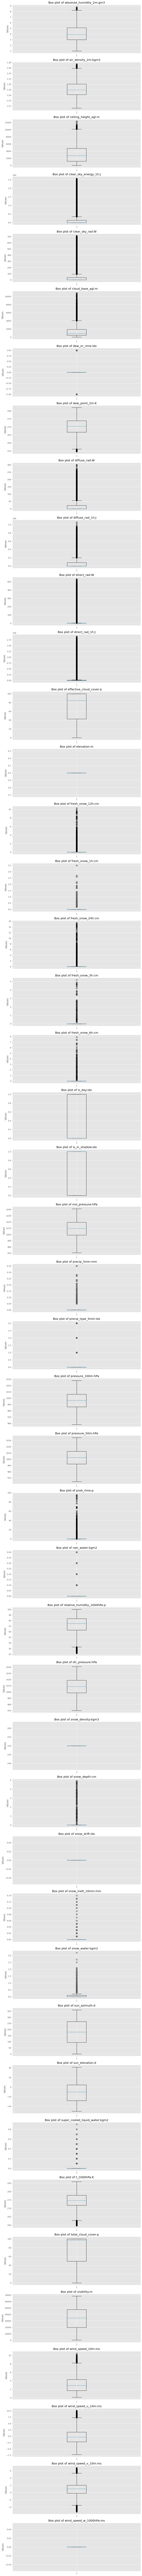

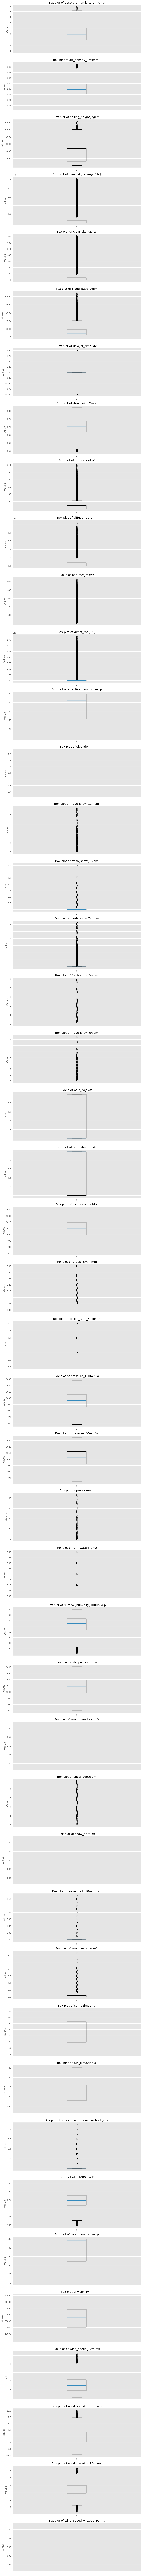

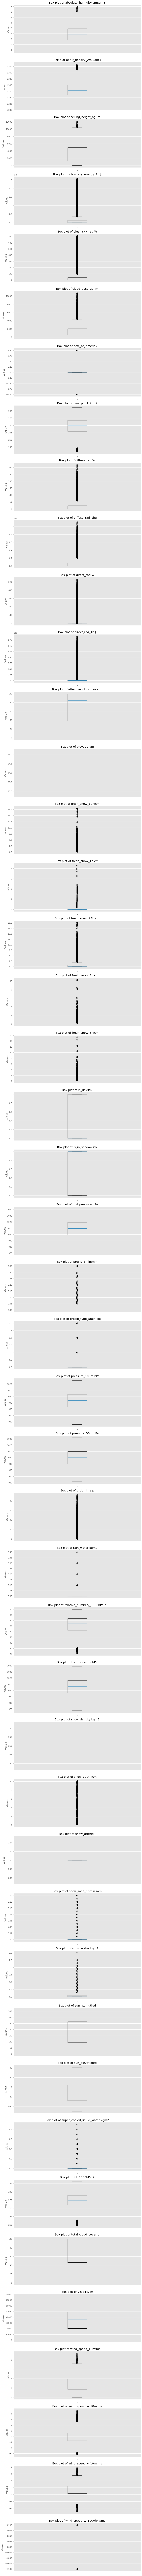

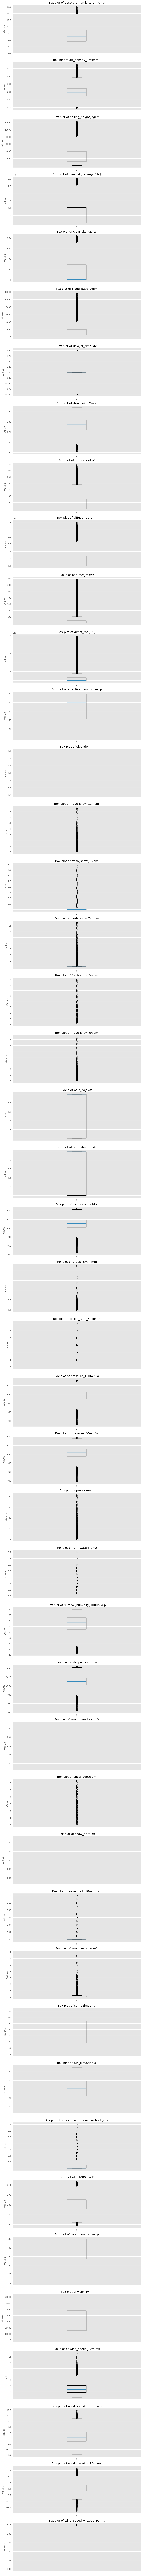

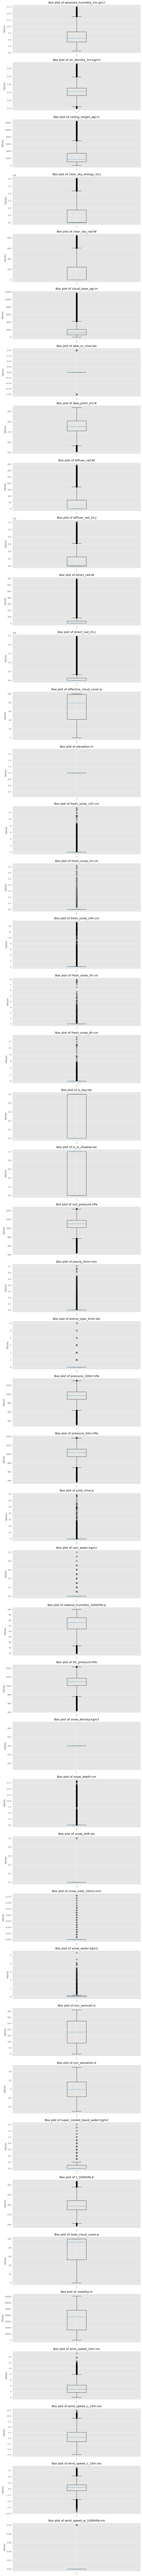

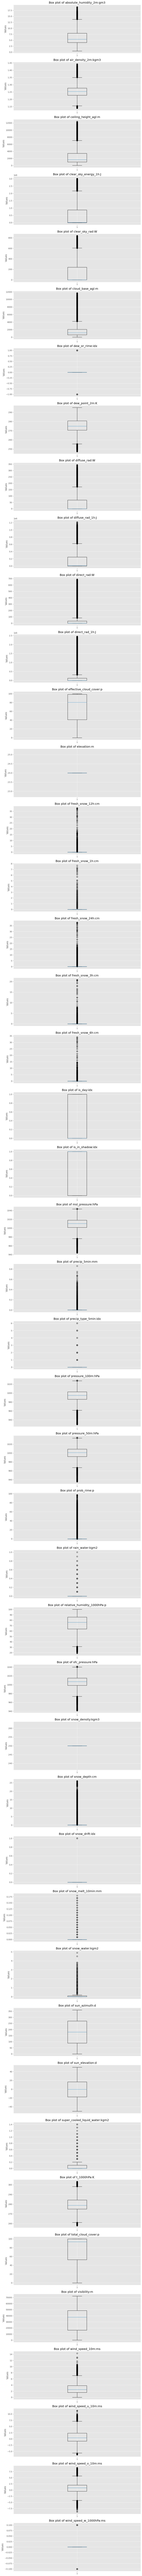

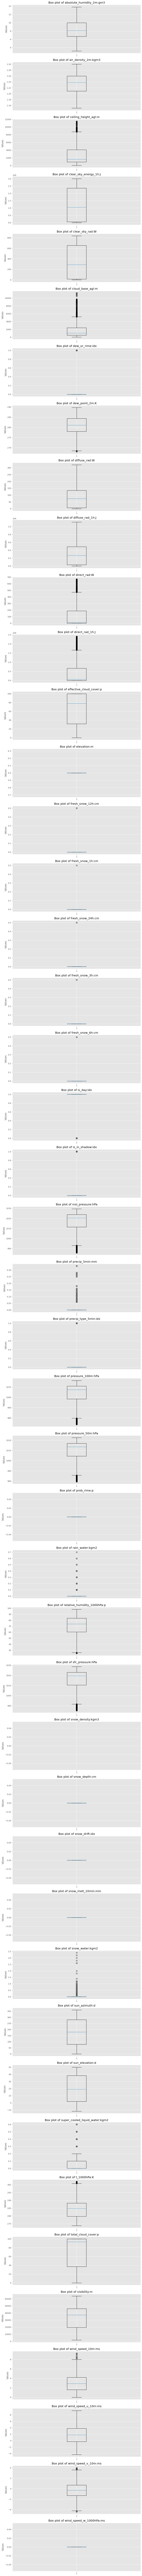

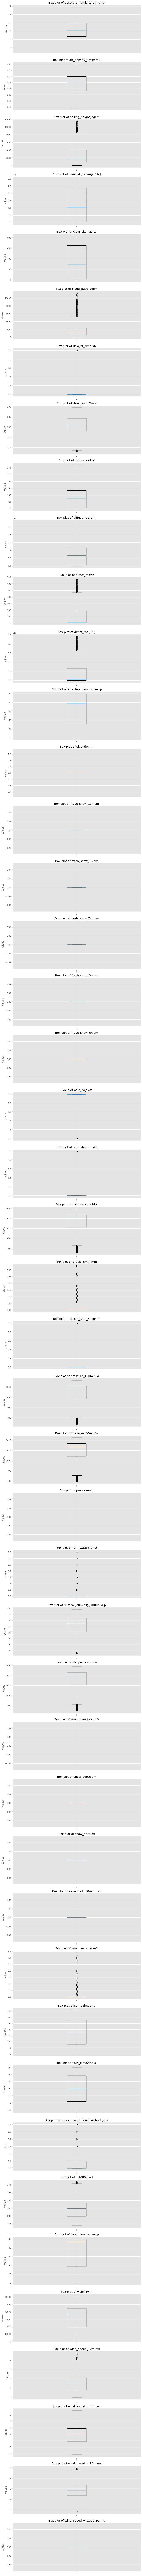

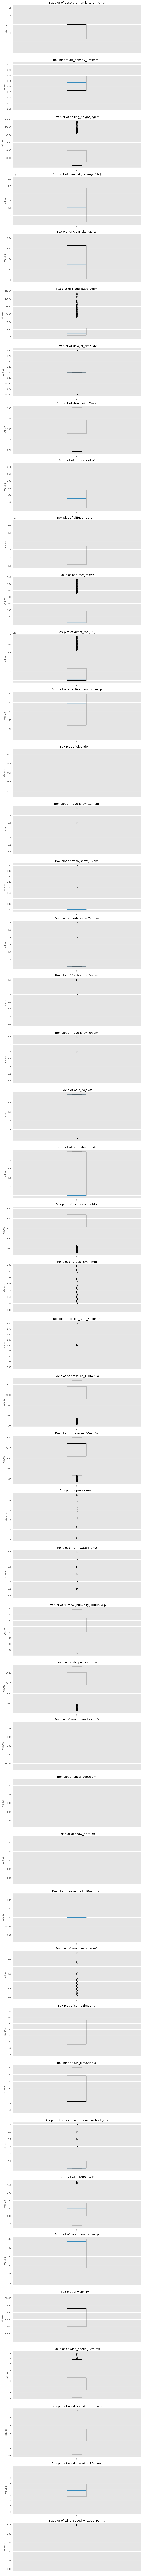

In [10]:
plot_boxplots(X_train_estimated_a, title = "X_train_estimated_a", show=True)
plot_boxplots(X_train_estimated_b, title = "X_train_estimated_b", show=True)
plot_boxplots(X_train_estimated_c, title = "X_train_estimated_c", show=True)
plot_boxplots(X_train_observed_a, title = "X_train_observed_a", show=True)
plot_boxplots(X_train_observed_b, title = "X_train_observed_b", show=True)
plot_boxplots(X_train_observed_c, title = "X_train_observed_c", show=True)
plot_boxplots(X_test_estimated_a, title = "X_test_estimated_a", show=True)
plot_boxplots(X_test_estimated_b, title = "X_test_estimated_b", show=True)
plot_boxplots(X_test_estimated_c, title = "X_test_estimated_c", show=True)

## Trend Analysis
This code will plot the actual pv_measurement values along with their rolling mean trend (computed over a 7-day window) for Location A. The shaded region represents the confidence intervals for the moving average. You can repeat similar plots for Locations B and C by calling the plot_moving_average function with their respective datasets.

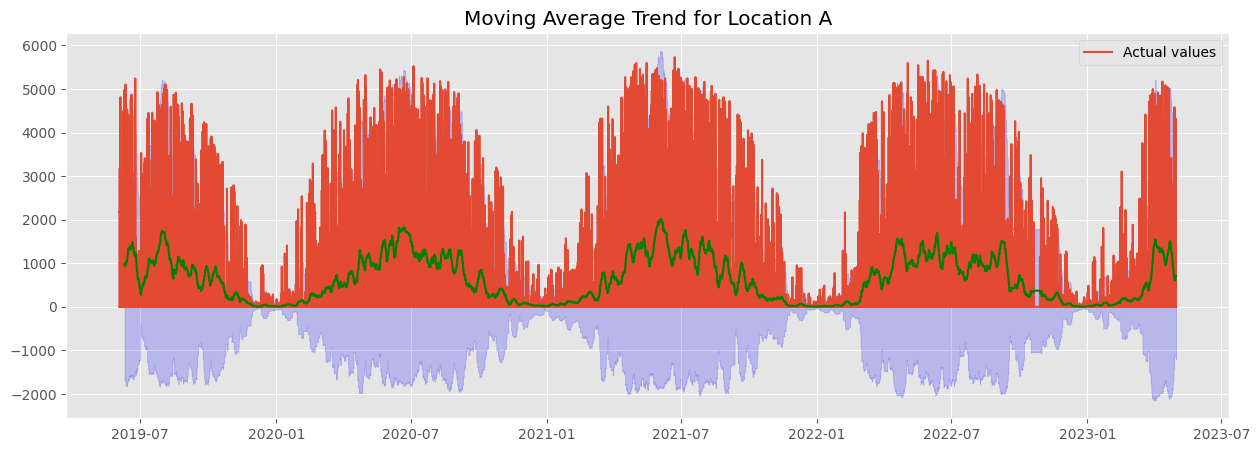

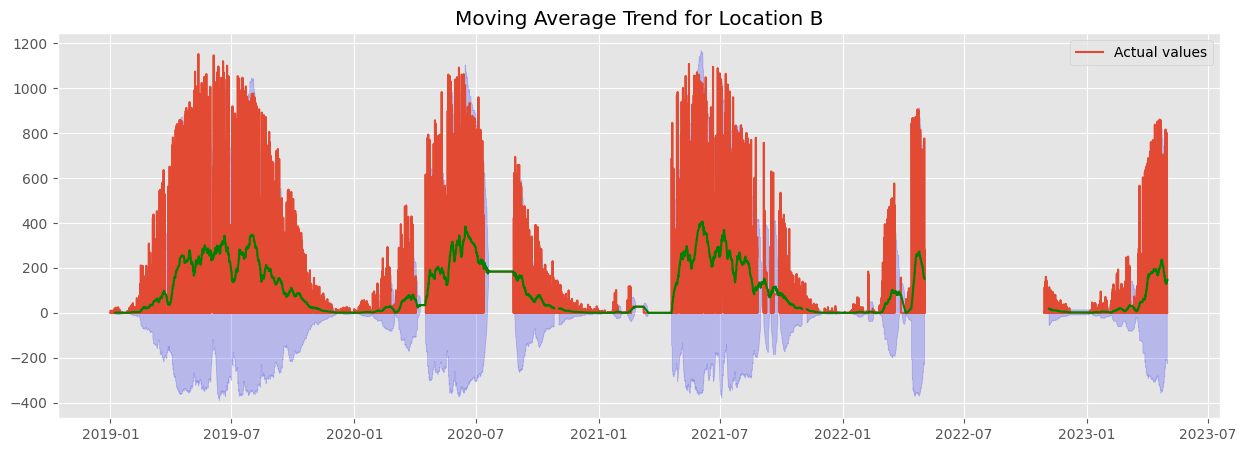

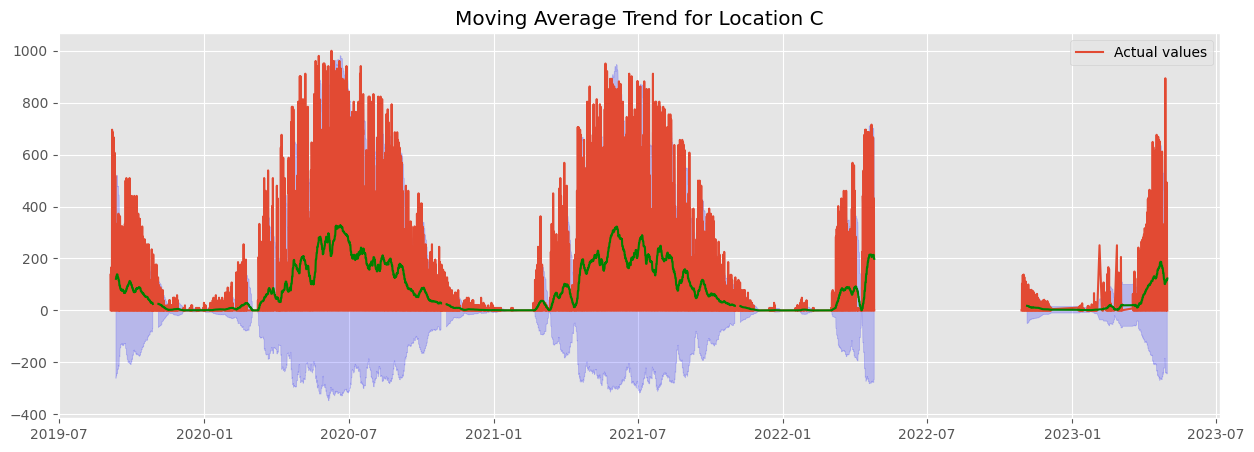

In [11]:
# Compute moving averages for trend analysis for Location A, B and C
plot_moving_average(targets_A['pv_measurement'], window=24*7, plot_intervals=True, title="Moving Average Trend for Location A")
plot_moving_average(targets_B['pv_measurement'], window=24*7, plot_intervals=True, title="Moving Average Trend for Location B")
plot_moving_average(targets_C['pv_measurement'], window=24*7, plot_intervals=True, title="Moving Average Trend for Location C")

## Seasonality analysis
Identifying recurring patterns or cycles in the data. For hourly data, you might find daily or monthly seasonality.

Seasonal Trends for Location A


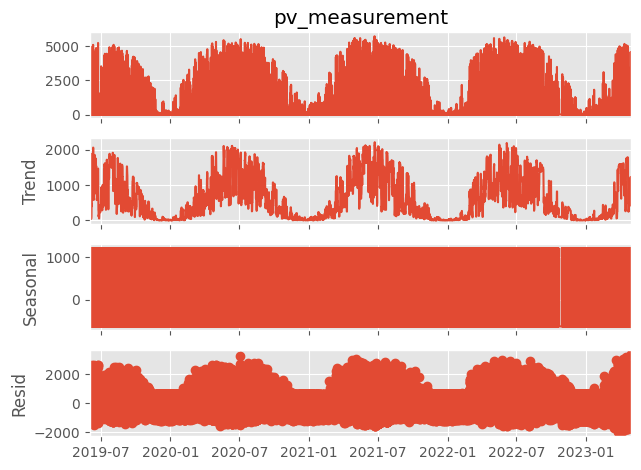

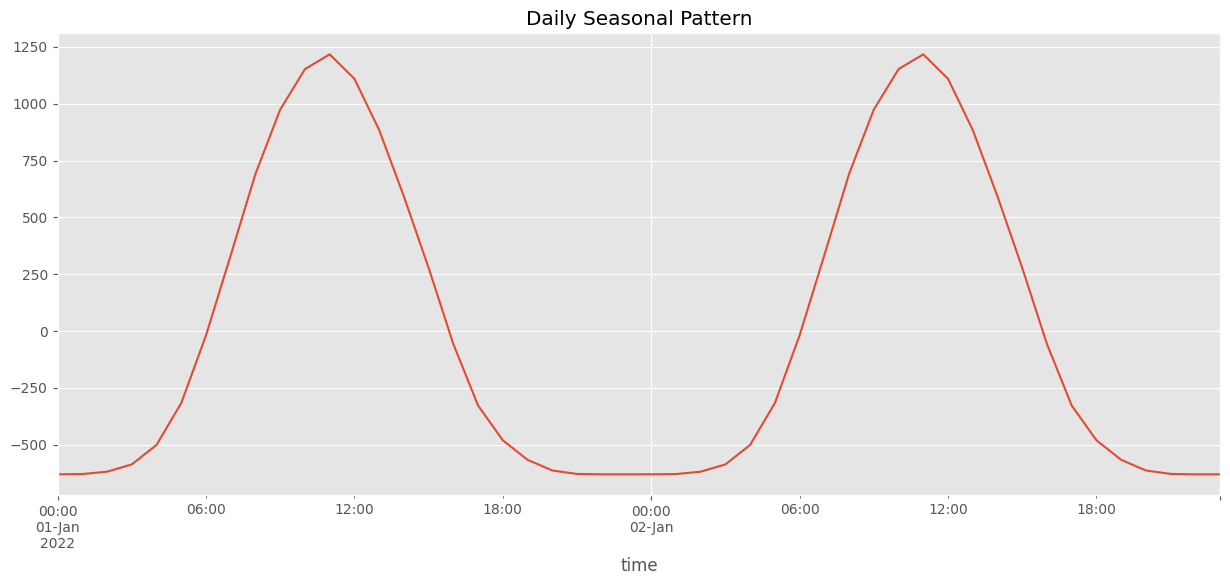

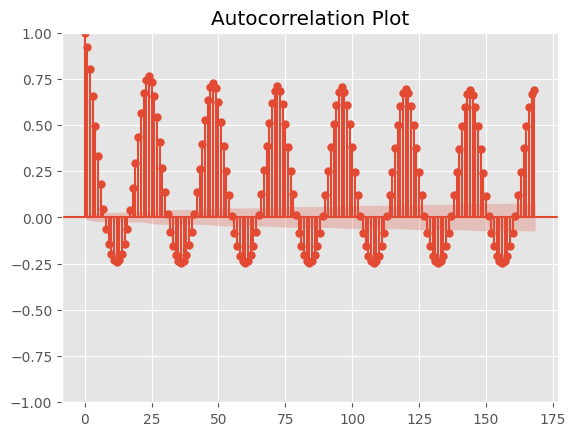

Seasonal Trends for Location B


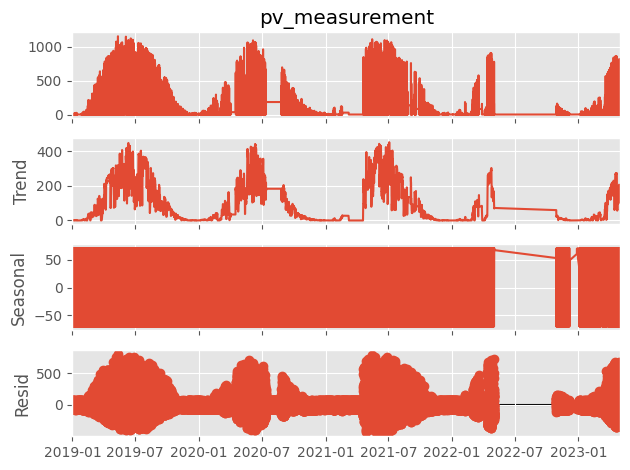

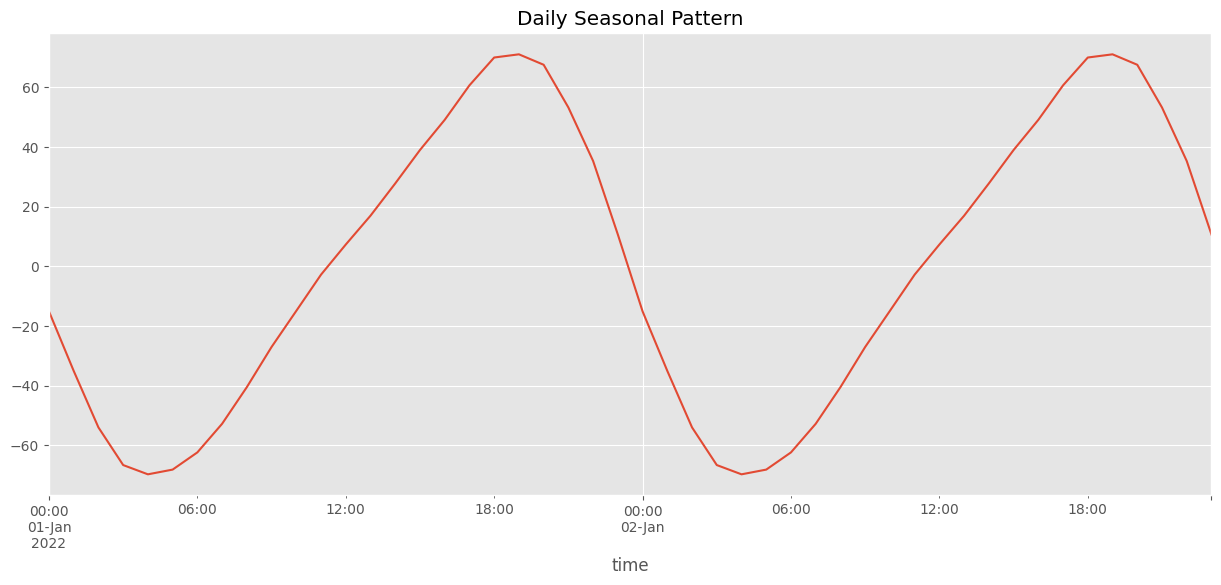

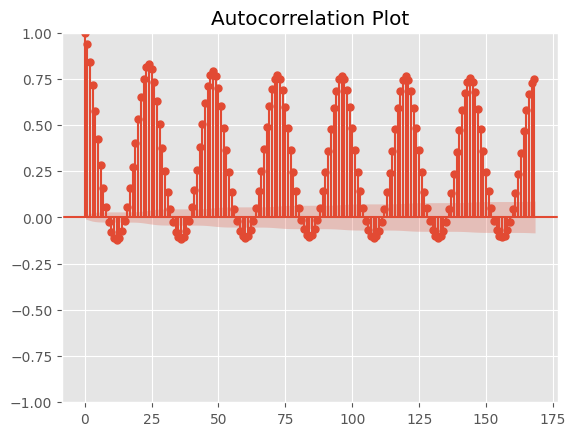

Seasonal Trends for Location C


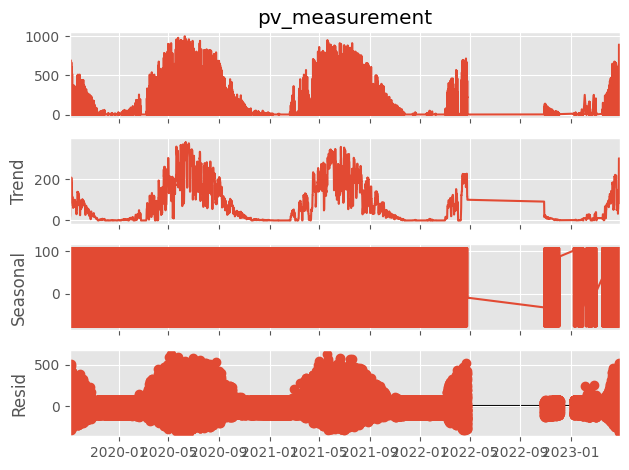

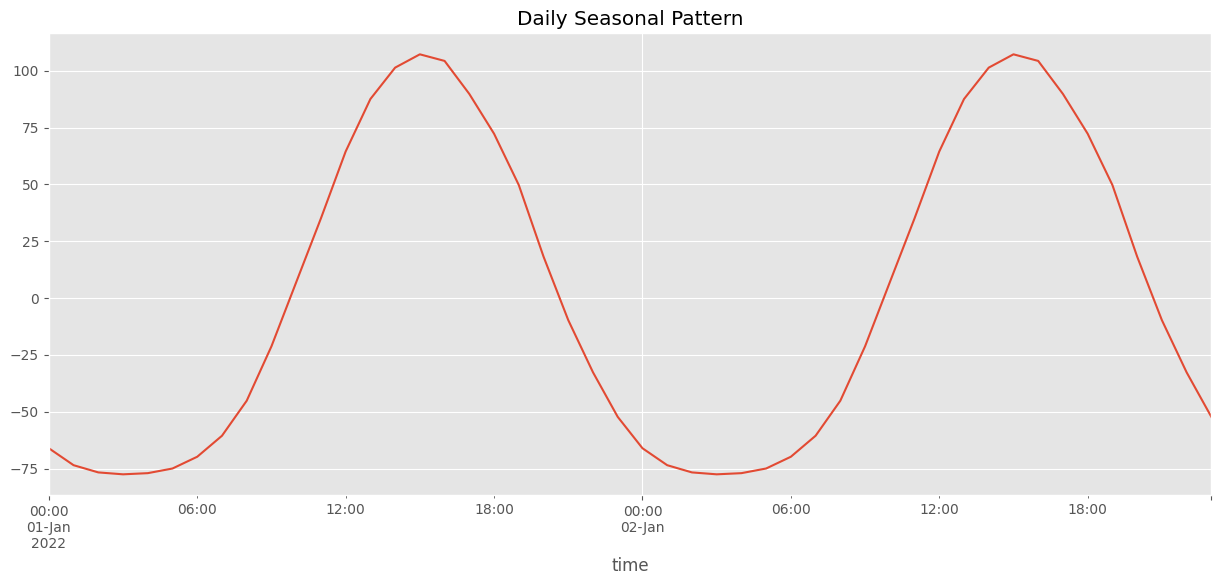

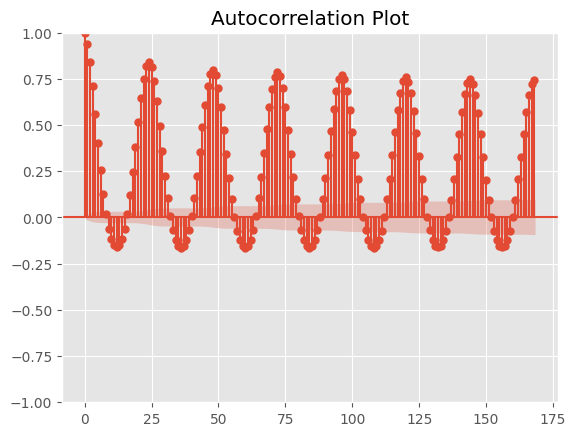

In [12]:
cleaned_targets_A = targets_A.copy()
cleaned_targets_B = targets_B.copy()
cleaned_targets_C = targets_C.copy()
# Remove nan values
cleaned_targets_A = cleaned_targets_A.dropna()
cleaned_targets_B = cleaned_targets_B.dropna()
cleaned_targets_C = cleaned_targets_C.dropna()

print("Seasonal Trends for Location A")
seasonal_trends(cleaned_targets_A, title="Seasonal Trends for Location A", show=True)
print("Seasonal Trends for Location B")
seasonal_trends(cleaned_targets_B, title="Seasonal Trends for Location B", show=True)
print("Seasonal Trends for Location C")
seasonal_trends(cleaned_targets_C, title="Seasonal Trends for Location C", show=True)

## Cyclicity: 
Unlike seasonality, which happens at fixed known periods, cycles are fluctuations that are not of a fixed frequency.

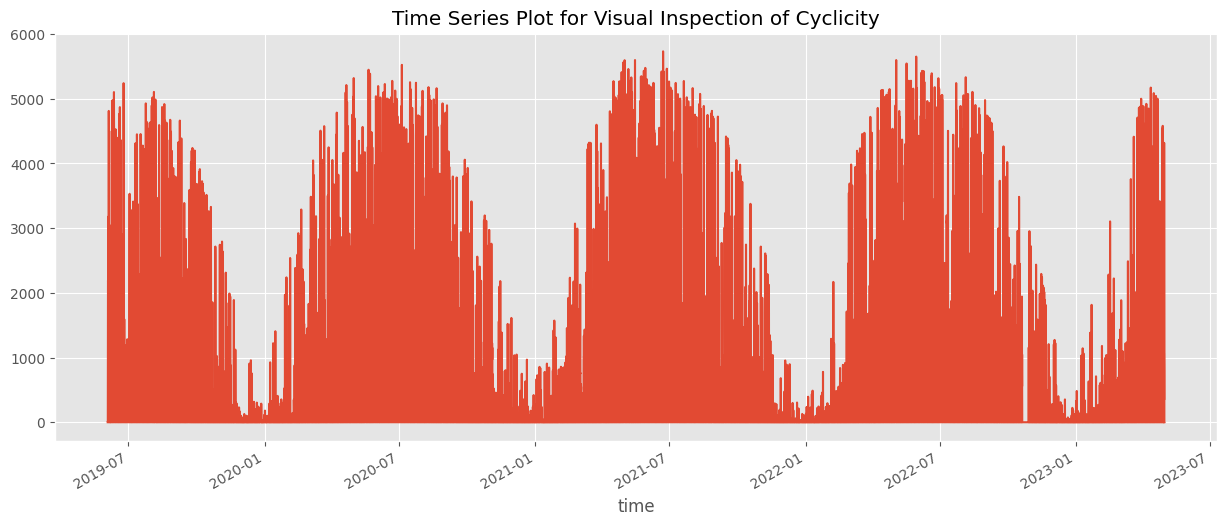

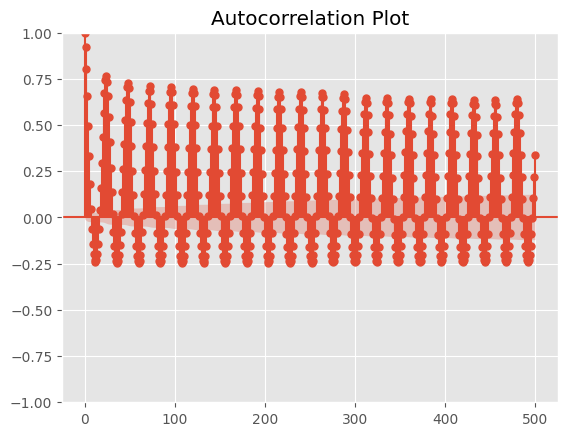

KeyboardInterrupt: 

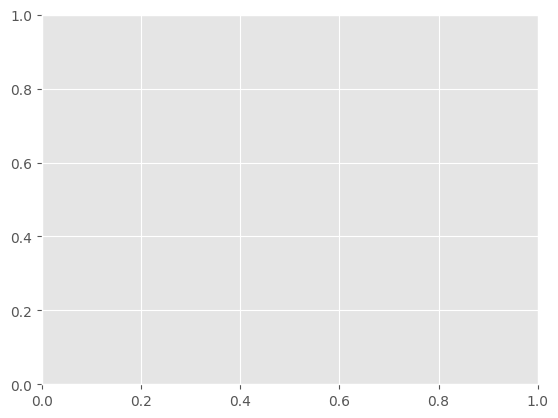

In [13]:
# Visual Inspection
plt.figure(figsize=(15,6))
targets_A['pv_measurement'].plot()
plt.title('Time Series Plot for Visual Inspection of Cyclicity')
plt.show()

# Autocorrelation plot
plot_acf(targets_A['pv_measurement'], lags=500)  # Adjust lags as needed to inspect longer periods
plt.title('Autocorrelation Plot')
plt.show()

# Partial autocorrelation plot
plot_pacf(targets_A['pv_measurement'], lags=500)  # Adjust lags as needed
plt.title('Partial Autocorrelation Plot')
plt.show()


#### Spectral analysis
Spectral analysis, specifically Fourier Transform, can be used to identify cyclic patterns in the data by decomposing the time series into its frequency components. The frequency components with the highest power are the ones that contribute most to the time series. The following code plots the power spectrum of the pv_measurement data for Location A. You can repeat similar plots for Locations B and C by calling the plot_power_spectrum function with their respective datasets.

In [ ]:
# Do spectral analysis for each location
A = targets_A.copy()
B = targets_B.copy()
C = targets_C.copy()
A = A.dropna()
B = B.dropna()
C = C.dropna()
spectral_analysis(A['pv_measurement'], title="Spectral Analysis for Location A", show=True)
spectral_analysis(B['pv_measurement'], title="Spectral Analysis for Location B", show=True)
spectral_analysis(C['pv_measurement'], title="Spectral Analysis for Location C", show=True)



#### Wavelet analysis
Wavelet analysis can be used to study the localized frequency behavior of the time series and is particularly useful when the time series has non-stationary or time-varying cyclic behaviors.

In [ ]:
print("CMOR Wavelet Analysis for Locations")
print("Wavelet Analysis for Location A")
wavelet_analysis(targets_A['pv_measurement'], wavelet='cmor', title="Wavelet Analysis for Location A", show=True)
print("Wavelet Analysis for Location B")
wavelet_analysis(targets_B['pv_measurement'], wavelet='cmor', title="Wavelet Analysis for Location B", show=True)
print("Wavelet Analysis for Location C")
wavelet_analysis(targets_C['pv_measurement'], wavelet='cmor', title="Wavelet Analysis for Location C", show=True)

print("MEXH Wavelet Analysis for Locations")

wavelet_analysis(targets_A['pv_measurement'], wavelet='mexh', title="Wavelet Analysis for Location A", show=True)
print("Wavelet Analysis for Location B")
wavelet_analysis(targets_B['pv_measurement'], wavelet='mexh', title="Wavelet Analysis for Location B", show=True)
print("Wavelet Analysis for Location C")
wavelet_analysis(targets_C['pv_measurement'], wavelet='mexh', title="Wavelet Analysis for Location C", show=True)


## Autocorrelation: 
It measures the relationship between a variable's current value and its past values. A lag plot or an autocorrelation function (ACF) plot can help in understanding this.

In [ ]:
# Plot the Autocorrelation Function

B = targets_B.copy()
C = targets_C.copy()
B.dropna(inplace=True)
C.dropna(inplace=True)

plot_acf_daily_weekly_monthly_yearly(targets_A, "pv_measurement", "target_a", show=True)
plot_acf_daily_weekly_monthly_yearly(B, "pv_measurement", "target_b", show=True)
plot_acf_daily_weekly_monthly_yearly(C, "pv_measurement", "target_c", show=True)

## Outlier Detection: 
Identifying unusual data points that might be errors or rare events. This can be done visually or with statistical methods.

In [ ]:
# Detect outliers
outliers_a = detect_outliers(targets_A['pv_measurement'], "Outliers for Location A")
outliers_b = detect_outliers(targets_B['pv_measurement'], "Outliers for Location B")
outliers_c = detect_outliers(targets_C['pv_measurement'], "Outliers for Location C")

## Distribution Analysis: 
Understanding the distribution of data can provide insights into its nature (e.g., normal vs. skewed, presence of heavy tails).

In [ ]:
# Usage example:
# Load the dataset for Location A
stat, p = analyze_normality(targets_A['pv_measurement'])

# Print the test statistic and p-value
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p}")

# Anderson-Darling Test
anderson_darling_test(targets_A['pv_measurement'])

After executing the code, you'll receive the result of the Shapiro-Wilk test. If the test indicates non-normality, you can then consider other distributions like log-normal, exponential, or even more domain-specific distributions like the Weibull distribution (often used for lifespan analyses). The choice of distribution should also be influenced by domain knowledge and the nature of the data.

## Feature Correlation
Correlation analysis can be used to identify highly correlated features. This can be done visually or with statistical methods. The following code plots the correlation matrix for the pv_measurement data for Location A. You can repeat similar plots for Locations B and C by calling the plot_correlation_matrix function with their respective datasets.
* Correlation measures linear relationships. Two variables might be related in non-linear ways that the correlation coefficient would not capture. Consider using other methods like mutual information for non-linear relationships.
* Correlation does not imply causation. Just because two variables are correlated doesn't mean one causes the other.
* Before removing any features, consider the impact on the model and the interpretability. Sometimes, even if two features are correlated, they might have different interpretations in a domain-specific context, and you might want to keep both.
* For tree-based models like decision trees and random forests, multicollinearity is less of an issue, as these models can handle correlated features well. However, for linear models and neural networks, it's essential to address highly correlated features.

In [ ]:
# Append target to features
X_train_observed_a_with_target = X_train_observed_a.copy()
X_train_observed_b_with_target = X_train_observed_b.copy()
X_train_observed_c_with_target = X_train_observed_c.copy()
X_test_estimated_a_with_target = X_test_estimated_a.copy()
X_test_estimated_b_with_target = X_test_estimated_b.copy()
X_test_estimated_c_with_target = X_test_estimated_c.copy()
X_train_estimated_a_with_target = X_train_estimated_a.copy()
X_train_estimated_b_with_target = X_train_estimated_b.copy()
X_train_estimated_c_with_target = X_train_estimated_c.copy()


X_train_observed_a_with_target.set_index('date_forecast', inplace=True)
X_train_observed_b_with_target.set_index('date_forecast', inplace=True)
X_train_observed_c_with_target.set_index('date_forecast', inplace=True)
X_test_estimated_a_with_target.set_index('date_forecast', inplace=True)
X_test_estimated_b_with_target.set_index('date_forecast', inplace=True)
X_test_estimated_c_with_target.set_index('date_forecast', inplace=True)
X_train_estimated_a_with_target.set_index('date_forecast', inplace=True)
X_train_estimated_b_with_target.set_index('date_forecast', inplace=True)
X_train_estimated_c_with_target.set_index('date_forecast', inplace=True)

X_train_observed_a_with_target['pv_measurement'] = targets_A['pv_measurement']
X_train_observed_b_with_target['pv_measurement'] = targets_B['pv_measurement']
X_train_observed_c_with_target['pv_measurement'] = targets_C['pv_measurement']  
X_test_estimated_a_with_target['pv_measurement'] = targets_A['pv_measurement']
X_test_estimated_b_with_target['pv_measurement'] = targets_B['pv_measurement']
X_test_estimated_c_with_target['pv_measurement'] = targets_C['pv_measurement']
X_train_estimated_a_with_target['pv_measurement'] = targets_A['pv_measurement']
X_train_estimated_b_with_target['pv_measurement'] = targets_B['pv_measurement']
X_train_estimated_c_with_target['pv_measurement'] = targets_C['pv_measurement']

plot_correlation_matrix(X_train_observed_a_with_target, title="Correlation Matrix X_train_observed_a_with_target for Location A", show=True)
plot_correlation_matrix(X_train_observed_b_with_target, title="Correlation Matrix X_train_observed_b_with_target for Location B", show=True)
plot_correlation_matrix(X_train_observed_c_with_target, title="Correlation Matrix X_train_observed_c_with_target for Location C", show=True)
plot_correlation_matrix(X_test_estimated_a_with_target, title="Correlation Matrix X_test_estimated_a_with_target for Location A", show=True)
plot_correlation_matrix(X_test_estimated_b_with_target, title="Correlation Matrix X_test_estimated_b_with_target for Location B", show=True)
plot_correlation_matrix(X_test_estimated_c_with_target, title="Correlation Matrix X_test_estimated_c_with_target for Location C", show=True)
plot_correlation_matrix(X_train_estimated_a_with_target, title="Correlation Matrix X_train_estimated_a_with_target for Location A", show=True)
plot_correlation_matrix(X_train_estimated_b_with_target, title="Correlation Matrix X_train_estimated_b_with_target for Location B", show=True)
plot_correlation_matrix(X_train_estimated_c_with_target, title="Correlation Matrix X_train_estimated_c_with_target for Location C", show=True)

## Feature Importance: 
If using machine learning models, understanding which features (in this case, weather parameters) are most influential in predicting solar energy production.
Lasso Regression (L1 Regularization):
* Lasso regression can be used to perform feature selection by shrinking some coefficients to zero, effectively excluding them from the model. The features with non-zero coefficients are considered important.
Recursive Feature Elimination (RFE):
RFE is a method that fits the model multiple times on iteratively reduced sets of features. It ranks features based on when they were eliminated.
Permutation Feature Importance:
This method involves randomly shuffling individual features and measuring how much the model's performance deteriorates. Important features will result in a significant drop in model performance when they're shuffled.
Feature Importance from Gradient Boosted Trees:
Models like XGBoost, LightGBM, and CatBoost provide feature importance scores similar to random forests but based on the structure of the boosted trees.

* SHAP (SHapley Additive exPlanations):
  SHAP values provide a unified measure of feature importance by averaging the marginal contributions of features across all possible combinations. It is model-agnostic and provides insights into how features influence predictions for individual observations.
* Correlation Coefficients:
  Features that have a higher correlation with the target variable might be considered more important. However, this method doesn't account for interactions between features.
* ANOVA F-values (for regression tasks):
  The F-values from a one-way ANOVA test can be used to rank features based on their variance with respect to the target variable. Higher F-values indicate more significant differences in the means and, hence, potentially more important features.
* Chi-Squared Test (for classification tasks):
  For categorical input features and a categorical target, the chi-squared test can assess the independence between each feature and the target. Larger chi-squared statistics indicate more dependency and, thus, potentially more importance.
  
The method or combination of methods you choose depends on the specific requirements of the task, the nature of your data, and the model you're working with. It's also beneficial to cross-reference multiple methods to get a more robust understanding of feature importance.

In [ ]:

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()

In [ ]:

# 1. Feature Importance using Linear Regression
lr = LinearRegression()
lr.fit(X_train_obs_combined, y_train_obs_combined)
coefficients = lr.coef_

# Plotting feature importance for Linear Regression
plt.figure(figsize=(30,10))
plt.bar(X_train_obs_combined.columns, coefficients)
plt.xticks(rotation=90)
plt.title('Feature Importance on observed using Linear Regression')
plt.savefig('results/figures/feature_importance/feature_importance_obs_using_linear_regression.png')
plt.show()

# 1. Feature Importance using Linear Regression
lr = LinearRegression()
lr.fit(X_train_est_combined, y_train_est_combined)
coefficients = lr.coef_

# Plotting feature importance for Linear Regression
plt.figure(figsize=(30,10))

plt.bar(X_train_est_combined.columns, coefficients)
plt.xticks(rotation=90)
plt.title('Feature Importance on estimate using Linear Regression')
plt.savefig('results/figures/feature_importance/feature_importance_obs_using_linear_regression.png')
plt.show()

# 2. Feature Importance using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_obs_combined, y_train_obs_combined)
importances = rf.feature_importances_

# Plotting feature importance for Random Forest
plt.figure(figsize=(30,10))

plt.bar(X_train_obs_combined.columns, importances)
plt.xticks(rotation=90)
plt.title('Feature Importance on observed using Random Forest')
plt.savefig('results/figures/feature_importance/feature_importance_obs_using_random_forest.png')

plt.show()

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_est_combined, y_train_est_combined)
importances = rf.feature_importances_

# Plotting feature importance for Random Forest
plt.figure(figsize=(15,6))
plt.bar(X_train_est_combined.columns, importances)
plt.xticks(rotation=90)
plt.title('Feature Importance on estimate using Random Forest')
plt.savefig('results/figures/feature_importance/feature_importance_est_using_random_forest.png')

plt.show()


## Residual Analysis: 
After fitting a model, analyzing the residuals (difference between predictions and actual values) can give insights into the model's accuracy and potential areas of improvement.

Residual analysis is an essential aspect of evaluating the performance and validity of a regression model. Residuals are the differences between the observed values and the values predicted by the model. Analyzing residuals helps in diagnosing the assumptions of linear regression, identifying outliers, and checking the fit of the model.

Here's a breakdown of the steps we'll take for residual analysis:

* Compute Residuals: We'll first fit a model (for this example, I'll use linear regression) to the data and compute the residuals.
* Residual Plots:
  * Residual vs. Fitted Plot: This plot helps in checking the assumption of linearity and equal variance (homoscedasticity). If there's a clear pattern or if the spread is not consistent, it indicates a problem.
  * Histogram and QQ-Plot: These plots help in checking the assumption of normally distributed residuals.
* Scale-Location Plot: Helps in checking the assumption of homoscedasticity.
* Residual vs. Leverage Plot: Helps in identifying influential cases that might be affecting the regression model disproportionately.

In [ ]:

# Fit the linear regression model
X = X_train_est_combined
y = y_train_est_combined
def residuals(X, y, show=True, title: str = "on estimate"): 
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    X = sm.add_constant(X)  # Adding a constant to the model (intercept)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    residuals = y - predictions

    # Residual vs. Fitted Plot
    plt.figure(figsize=(10,6))
    sns.residplot(x=predictions, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residual vs. Fitted Plot {title}')
    plt.savefig(f'results/figures/residuals/residual_vs_fitted_plot_on_{title}.png')
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(10,6))
    sns.histplot(residuals, kde=True)
    plt.title(f'Histogram of Residuals {title}')
    plt.savefig(f'results/figures/residuals/histogram_of_residuals_on_{title}.png')
    plt.show()

    # QQ-Plot
    qqplot(residuals, line='s')
    plt.title('QQ-Plot')
    plt.show()

    # Scale-Location Plot
    plt.figure(figsize=(10,6))
    sns.regplot(x=predictions, y=np.sqrt(np.abs(residuals)), lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.ylabel('Standardized Residuals')
    plt.xlabel('Fitted values')
    plt.title(f'Scale-Location Plot {title}')
    plt.savefig(f'results/figures/residuals/scale_location_plot_on_{title}.png')
    plt.show()

    # Residuals vs. Leverage Plot
    from statsmodels.graphics.regressionplots import plot_leverage_resid2
    fig, ax = plt.subplots(figsize=(10,6))
    fig = plot_leverage_resid2(model, ax=ax)
    plt.title(f'Residuals vs. Leverage Plot {title}')
    plt.savefig(f'results/figures/residuals/residuals_vs_leverage_plot_on_{title}.png')
    plt.show()

residuals(X, y, show=True, title="on estimate")
X = X_train_obs_combined
y = y_train_obs_combined
residuals(X, y, show=True, title="on observed")


## Domain-Specific Insights: 
Since this data deals with solar energy production, domain knowledge about factors affecting solar panel efficiency, degradation over time, and other domain-specific considerations can be invaluable.


Here are some domain-specific insights related to solar energy:

Sunlight Intensity: Solar panel output is directly proportional to the sunlight's intensity. Hence, periods with more intense sunlight (e.g., mid-day) will typically have higher solar production.

Weather Conditions:

* Cloud Cover: Overcast days can significantly reduce solar panel output.
* Temperature: While sunlight is the primary driver of solar panel output, temperature can also play a role. Solar panel efficiency can decrease as temperature rises, meaning on very hot days, the panels might produce slightly less energy than on cooler sunny days.
* Rain and Snow: Rain can reduce solar panel efficiency by blocking sunlight. Snow, especially if it covers the panels, can halt production entirely.
* Seasonal Variations: Due to the tilt of the Earth's axis, the angle and duration of sunlight vary throughout the year. This leads to seasonal variations in solar production.

Solar Panel Degradation: Over time, solar panels degrade and become less efficient. Typically, solar panels degrade at a rate of about 0.5% to 1% per year. This means that the same panel will produce slightly less energy each year.

Orientation and Tilt of Solar Panels: The direction that solar panels face (often towards the equator) and their tilt can have a significant effect on their energy production.

Dirt and Debris: Dirt, dust, and other debris can accumulate on solar panels and reduce their efficiency. Regular cleaning can help maintain optimal production.

Shadowing: Shadows from nearby structures or trees can reduce solar panel output. Even a small amount of shade on a panel can reduce its output significantly.

System Issues: Technical issues, such as inverter problems, can reduce the efficiency of solar energy systems.

Policy and Grid Factors: Factors external to the physical system can also influence solar energy production data. For instance, if a grid is at capacity and cannot take on additional solar energy, solar installations might be curtailed.

Economic and Behavioral Factors: Economic incentives, such as feed-in tariffs, can influence the amount of solar energy fed into the grid. Similarly, energy storage solutions, like batteries, can influence when solar energy is used versus stored.

# Exploratory PCA and CCA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined])
pd.set_option('display.max_columns', None)

In [ ]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# Generate some sample data
np.random.seed(0)
X = np.random.rand(100, 3)  # first set of variables
Y = np.random.rand(100, 3)  # second set of variables

# Step 1: Standardize the data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_std = scaler_X.fit_transform(X)
Y_std = scaler_Y.fit_transform(Y)

# Step 2-5: Apply CCA
n_components = 2
cca = CCA(n_components=n_components)
X_c, Y_c = cca.fit_transform(X_std, Y_std)

print("Transformed X with CCA:\n", X_c)
print("Transformed Y with CCA:\n", Y_c)


## PCA

In [ ]:
# Step 1: Standardize the data
scaler_X = StandardScaler()
data_std = scaler_X.fit_transform(x_whole)

# Step 2-6: Apply PCA
n_components = 25
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_std)

print("Transformed data with PCA:\n", data_pca)
print("Explained variance by each component:", pca.explained_variance_ratio_)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

print("Component Loadings:\n", pca.components_)



## CCA

In [ ]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# Generate some sample data
np.random.seed(0)
X = np.random.rand(100, 3)  # first set of variables
Y = np.random.rand(100, 3)  # second set of variables

# Step 1: Standardize the data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_std = scaler_X.fit_transform(X)
Y_std = scaler_Y.fit_transform(Y)

# Step 2-5: Apply CCA
n_components = 2
cca = CCA(n_components=n_components)
X_c, Y_c = cca.fit_transform(X_std, Y_std)

print("Transformed X with CCA:\n", X_c)
print("Transformed Y with CCA:\n", Y_c)


Canonical Correlations: These are the correlations between the canonical variables obtained from the two datasets. They give you a sense of how well the canonical variables from each dataset are related.

In [ ]:
print("Canonical loadings for X:\n", cca.x_loadings_)
print("Canonical loadings for Y:\n", cca.y_loadings_)

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(X_c[:,0], Y_c[:,0], label='First Canonical Variable')
plt.scatter(X_c[:,1], Y_c[:,1], label='Second Canonical Variable')
plt.xlabel('Canonical X')
plt.ylabel('Canonical Y')
plt.title('Scatter plot of Canonical Variables')
plt.legend()
plt.show()


# Exploratory Feature Engineering

## Load all data both preprocessed and raw

In [ ]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()
X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined])
estimated_data = pd.concat([X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined])
# x_whole.reset_index(drop=True, inplace=True)
# y_whole.reset_index(drop=True, inplace=True)
pd.set_option('display.max_columns', None)


x_whole["time_since_prediction"].describe()

In [ ]:
X_train_est_combined["time_since_prediction"].describe()

In [ ]:
y_whole.sort_index(inplace=True)
y_whole.shape

In [ ]:
top_50 = y_whole.value_counts().head(50)

# Print the results
print(top_50)

In [ ]:

def plot_pv_measurement_by_dataframe(dataframes: list, labels: list, show: bool = False) -> None:
    segment_size = 24*7*4
    
    # Loop through each dataframe and its label
    for df, label in zip(dataframes, labels):

        # Determine the number of segments for the current dataframe
        num_segments = len(df) // segment_size + (len(df) % segment_size > 0)

        # Loop through each segment
        for i in range(num_segments):
            # Select the segment of data
            start_idx = i * segment_size
            end_idx = start_idx + segment_size
            segment = df.iloc[start_idx:end_idx]

            # Create a new figure for each segment
            plt.figure(figsize=(20, 10))

            # Plot a standard line graph
            plt.plot(segment.index, segment['pv_measurement'], color='red', linewidth=2)

            # Add black dots for each data point using scatter
            plt.scatter(segment.index, segment['pv_measurement'], color='black', s=30)

            plt.title(f'{label} Segment: {i+1}')
            plt.ylabel('PV Measurement')
            plt.xlabel('Date')

            if show:
                plt.show()

            # Consider saving each figure with a unique name
            # plt.savefig(f'results/figures/{label}/new_pv_measurement_segment_{i+1}.png')

            plt.close()

# Example Usage
dataframes = [train_a, train_b, train_c]
labels = ['location_a', 'location_b', 'location_c']
plot_pv_measurement_by_dataframe(dataframes, labels, show=True)

In [ ]:

data_with_target = pd.concat([x_whole, y_whole], axis=1)



plot_correlation_matrix(data_with_target, "data_with_target", show=True)

In [ ]:


data_with_target_a = data_with_target[data_with_target['location_a'] == 1]
# data_with_target_a = data_with_target_a[(data_with_target_a['sun_azimuth:d'] >= 230) & (data_with_target_a['sun_azimuth:d'] <= 300)]


fig, axs = plt.subplots(5, 10, figsize=(18, 10))  # Create a grid of 5x9 subplots

# Flatten the axis array and iterate over both the flattened array and the column names
# Assuming df is your DataFrame and you have stored all feature names in a list called feature_names
for ax, feature in zip(axs.flatten(), data_with_target_a.columns):
    ax.scatter(data_with_target_a[feature], data_with_target_a['pv_measurement'], s=0.01)  # Replace with your column names
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('pv_measurement')

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.title("Location A")
plt.savefig("results/figures/feature_engineering/location_a_correlation_with_pv.png")
plt.show()

In [ ]:
filtered_df = data_with_target[data_with_target['prob_rime:p'] > 10]
filtered_df.shape

In [ ]:
filtered_df = data_with_target[data_with_target['prob_rime:p'] == 0]
filtered_df = filtered_df[filtered_df["dew_or_rime:idx"] != 0]
filtered_df.shape

In [ ]:
data_with_target_a["sun_azimuth:d"].describe()
sorted_df = data_with_target_a.sort_values(by='pv_measurement', ascending=False)
mean_azimuth = sorted_df.iloc[:1000]['sun_azimuth:d'].mean()
print(mean_azimuth)

In [ ]:
data_with_target_b = data_with_target[data_with_target['location_b'] == 1]
fig, axs = plt.subplots(5, 10, figsize=(18, 10))  # Create a grid of 5x9 subplots

# Flatten the axis array and iterate over both the flattened array and the column names
# Assuming df is your DataFrame and you have stored all feature names in a list called feature_names
for ax, feature in zip(axs.flatten(), data_with_target_b.columns):
    ax.scatter(data_with_target_b[feature], data_with_target_b['pv_measurement'], s=0.01)  # Replace with your column names
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('pv_measurement')

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.title("Location B")
plt.savefig("results/figures/feature_engineering/location_b_correlation_with_pv.png")
plt.show()

In [ ]:
data_with_target_c = data_with_target[data_with_target['location_c'] == 1]
fig, axs = plt.subplots(5, 10, figsize=(18, 10))  # Create a grid of 5x9 subplots

# Flatten the axis array and iterate over both the flattened array and the column names
# Assuming df is your DataFrame and you have stored all feature names in a list called feature_names
for ax, feature in zip(axs.flatten(), data_with_target_c.columns):
    ax.scatter(data_with_target_c[feature], data_with_target_c['pv_measurement'], s=0.01)  # Replace with your column names
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('pv_measurement')

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.title("Location C")
plt.savefig("results/figures/feature_engineering/location_c_correlation_with_pv.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has columns 'effective_radiation' and 'pv_measurement'

plt.figure(figsize=(10,6))  # You can adjust the size as needed

# Scatter plot
plt.scatter(data_with_target['effective_radiation'], data_with_target['pv_measurement'], color='blue')  # you can choose the color

# Adding a vertical line at x=0.9
plt.axvline(x=0.85, color='pink')  # Here, 'x' is the position of the vertical line on the x-axis

# Adding titles and labels
plt.title('PV Measurement vs Effective Radiation')
plt.xlabel('Effective Radiation')
plt.ylabel('PV Measurement')

# Show plot
plt.show()

In [ ]:

# pd.set_option('display.max_rows', 200)

mask = (data_with_target["effective_solar_elevation"] < -0.1) & (data_with_target['pv_measurement'] >0)

# Apply the mask to get the desired rows
filtered_df = data_with_target[mask]


filtered_df.head(10)


In [ ]:

mask = (data_with_target['global_horizontal_irradiation'] == 0) & (data_with_target['pv_measurement'] >0)

# Apply the mask to get the desired rows
filtered_df = data_with_target[mask]


filtered_df.shape


In [ ]:
data_with_target

mask = (data_with_target['prob_rime:p'] > 10)

# Apply the mask to get the desired rows
filtered_df = data_with_target[mask]


filtered_df.head(200)

# Different models
In this section we will show different models and how they perform on the data. 

## Stacking of models into two layers
1. First layer: train models on the whole training set
2. Second layer: train a model on the first layer's predictions and the rest of the training set

In [ ]:
%pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb
import pandas as pd

pd.set_option('display.max_columns', 200)
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')



### Configure running

In [ ]:
load_xgb: bool = False
load_lgb: bool = False
load_cat: bool = False
load_rf:  bool = False
load_svr: bool = False

### Get the data

In [ ]:
X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head()

## Train test split for the base layer and meta layer

In [ ]:
# The base layer gets 80% of the data
# The meta layer gets 20% of the data
base_to_meta_layer_split = 0.8

base_x_train = x_whole.sample(frac=base_to_meta_layer_split)
meta_x_train = x_whole.sample(frac=1-base_to_meta_layer_split)

# Get the corresponding y values
base_y_train = y_whole[base_x_train.index]
meta_y_train = y_whole[meta_x_train.index]
base_x_train.columns

### Train Base level models
It is important to use a variety of models to get a diverse set of predictions.

I want a model to check if there is a linear relationship between the location features and the target. I will use a linear regression model for this.
I want to check if the different irradiation values are correlated with the target. I will use xgboost for this.
I want to check if the different temperature values are correlated with the target. I will use 


### XGBoost
The XGBoost model is a gradient boosting model. It is a tree based model that uses the gradient descent algorithm to minimize the loss function. The loss function is a combination of the training loss and a regularization term. The regularization term is used to prevent overfitting. The model is trained on the training set and the validation set is used to check if the model is overfitting. The model is then trained on the whole training set and the test set is used to check the model's performance.

Utilizing k-fold cross validation to train the model on different subsets of the training set and validate on the rest of the training set. This is done to prevent overfitting.

In [ ]:
# K-fold cross validation
if not load_xgb:
    num_folds = 10
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0

    xgboost_models = []


    for train_index, test_index in kf.split(base_x_train):
        reg = xgb.XGBRegressor(n_estimators=10000000,
                        early_stopping_rounds=50,
                        learning_rate= 0.001,
                        objective="reg:linear",
                        eval_metric="mae",
                        sub_sample = 0.9,
                        colsample_bytree = 1.0,
                        gamma = 0,
                        min_child_weight=0,
                        max_depth=9)

        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]
        
        # Create sample weights for training data
        sample_weight_train = np.where(X_train['time_since_prediction'] == 0, 1, 2)
        # Create sample weights for testing data
        sample_weight_test = np.where(X_test['time_since_prediction'] == 0, 1, 2)
        
        reg.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                sample_weight=sample_weight_train,
                sample_weight_eval_set=[sample_weight_test],  # Here's how you pass the eval weights
                verbose=100)
        
        xgboost_models.append(reg)
        predictions = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions, sample_weight=sample_weight_test)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

### Catboost - first attempt
Tried using cross validation to early stop, however we went away from that after plateuing and suspecting overfitting

In [ ]:
if not load_cat:
    num_folds = 10
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0
    catboost_models = []

    def compute_sample_weight(data):
        # Assign weight of 2 for estimated data and 1 for observed data
        return np.where(data['time_since_prediction'] > 0, 2, 1)

    for train_index, test_index in kf.split(base_x_train):
        reg = CatBoostRegressor(
            iterations=10000000,
            depth=8,
            learning_rate=0.001,
            loss_function='MAE',
            verbose=200
        )
        
        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]
        
        # Compute sample weights for training and testing data
        train_weight = compute_sample_weight(X_train)
        test_weight = compute_sample_weight(X_test)

        # Create Pool for training and testing
        train_pool = Pool(data=X_train, label=y_train, weight=train_weight)
        test_pool = Pool(data=X_test, label=y_test, weight=test_weight)

        # Fit the model using the sample weights
        reg.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

        catboost_models.append(reg)
        predictions = reg.predict(test_pool)
        
        # Compute weighted MAE manually
        weighted_mae = np.sum(test_weight * np.abs(y_test - predictions)) / np.sum(test_weight)
        total_mae += weighted_mae
        
        print(f"Fold {len(catboost_models)}, Weighted Mean Absolute Error: {weighted_mae}")

    average_mae = total_mae / num_folds
    print(f"Average Weighted Mean Absolute Error: {average_mae}")


### lightgbm
Never got any good results with this model and stopped trying


In [ ]:
if not load_lgb:
    num_folds = 10
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    total_mae = 0

    lightgbm_models = []

    params = {
        'objective': 'regression_l1',
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'metric': 'mae',
        'num_leaves': 128,
        'learning_rate': 0.001,
        'feature_fraction': 1.0,
        'bagging_fraction': 0.9,
        'bagging_freq': 5,
        'min_data_in_leaf': 20,
        'early_stopping_rounds': 100,
        'verbosity': -1,  # 0 for verbose, -1 for silent
    }

    num_round = 10000000 # number of training iterations

    # Ensure column names are compatible with LightGBM
    base_x_train.columns = base_x_train.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

    for train_index, test_index in kf.split(base_x_train):
        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test)

        reg = lgb.train(params, train_data, num_round, valid_sets=[valid_data])
        lightgbm_models.append(reg)
        predictions = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

### Random Forest
Simple random forest

In [ ]:
if not load_rf:
    # K-fold cross validation
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0

    random_forest_models = []


    for train_index, test_index in kf.split(base_x_train):

        rf_model = RandomForestRegressor(n_estimators=200, max_depth=25, random_state=42)

        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

        # Train the Random Forest model on the cleaned training data
        
        rf_model.fit(X_train, y_train)
        
        random_forest_models.append(rf_model)
        predictions = rf_model.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

### Swarm Vector Regression

In [ ]:
if not load_svr:
    # K-fold cross validation
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0
    svr_models = []

    for train_index, test_index in kf.split(base_x_train):
        # Train an SVR model
        svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

        # Train the Swarm Vector Regression model on the cleaned training data
        svr.fit(X_train, y_train)

        svr_models.append(svr)
        predictions = rf_model.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")



### load the models and save the newly trained models

In [ ]:
# Check what models should be loaded
# Load XGBoost models
if load_xgb:
    with open("xgboost_models_stack.pkl", "rb") as file:
        xgboost_models = pickle.load(file)
        print(f"[LOADED] xgboost_models {len(xgboost_models)} has successfully been loaded")
else:
    with open("xgboost_models_stack.pkl", "wb") as file:
        pickle.dump(xgboost_models, file)
        print(f"[SAVED] xgboost_models has successfully been saved.")

# Load CatBoost models
if load_cat:
    with open("catboost_models_stack.pkl", "rb") as file:
        catboost_models = pickle.load(file)
        print(f"[LOADED] catboost_models {len(catboost_models)} has successfully been loaded")
else:
    with open("catboost_models_stack.pkl", "wb") as file:
        pickle.dump(catboost_models, file)
        print(f"[SAVED] catboost_models has successfully been saved.")

# Load lightGBM models
if load_lgb:
    with open("lightgbm_models_stack.pkl", "rb") as file:
        lightgbm_models = pickle.load(file)
        print(f"[LOADED] lightgbm_models {len(lightgbm_models)} has successfully been loaded")
else:
    with open("lightgbm_models_stack.pkl", "wb") as file:
        pickle.dump(lightgbm_models, file)
        print(f"[SAVED] lightgbm_models has successfully been saved.")

# Load random forest models
if load_rf:
    with open("random_forest_models_stack.pkl", "rb") as file:
        random_forest_models = pickle.load(file)
        print(f"[LOADED] random_forest_models {len(random_forest_models)} has successfully been loaded")
else:
    with open("random_forest_models_stack.pkl", "wb") as file:
        pickle.dump(random_forest_models, file)
        print(f"[SAVED] random_forest_models has successfully been saved.")

# Load SVR models
if load_svr:
    with open("svr_models_stack.pkl", "rb") as file:
        svr_models = pickle.load(file)
        print(f"[LOADED] svr_models {len(svr_models)} has successfully been loaded")
else:
    with open("svr_models_stack.pkl", "wb") as file:
        pickle.dump(svr_models, file)
        print(f"[SAVED] svr_models has successfully been saved.")


In [ ]:
def average_prediction(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return results


# Train meta learner model
Create dataset for meta learner model by using models to predict on the meta layer training set

In [ ]:
# Predict on the base layer on meta_x_train
base_xgboost_predictions  = average_prediction(meta_x_train, xgboost_models)
base_catboost_predictions = average_prediction(meta_x_train, catboost_models)
base_lightgbm_predictions = average_prediction(meta_x_train, lightgbm_models)
base_random_forest_predictions = average_prediction(meta_x_train, random_forest_models)
base_swarm_vector_regression_predictions = average_prediction(meta_x_train, svr_models)

# Add the predictions to the meta_x_train
meta_base_x_train = pd.DataFrame()
meta_base_x_train["xgboost"] = base_xgboost_predictions
meta_base_x_train["catboost"] = base_catboost_predictions
meta_base_x_train["lightgbm"] = base_lightgbm_predictions
meta_base_x_train["random_forest"] = base_random_forest_predictions
meta_base_x_train["swarm_vector_regression"] = base_swarm_vector_regression_predictions


Train meta learner model on new dataset

In [ ]:
# K-fold cross validation

num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0

meta_models = []


for train_index, test_index in kf.split(meta_base_x_train):

    reg = xgb.XGBRegressor(n_estimators=100000,
                       early_stopping_rounds=50,
                       learning_rate= 0.01,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0,
                       alpha = 0.001,
                       min_child_weight=0,
                       max_depth=4)

    X_train, X_test = meta_base_x_train.iloc[train_index], meta_base_x_train.iloc[test_index]
    y_train, y_test = meta_y_train.iloc[train_index], meta_y_train.iloc[test_index]

    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=100)
    
    meta_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(100,100))
plt.tight_layout()
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [ ]:
y_pred_val_obs_combined = average_prediction(X_val_obs_combined, meta_models)
y_pred_val_est_combined = average_prediction(X_val_est_combined, meta_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_val_obs_combined, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_val_est_combined, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


## Get predictions for meta learner model test set

In [ ]:
# Predict on the base layer on meta_x_train
base_xgboost_predictions  = average_prediction(x_test_whole, xgboost_models)
base_catboost_predictions = average_prediction(x_test_whole, catboost_models)
base_lightgbm_predictions = average_prediction(x_test_whole, lightgbm_models)
base_random_forest_predictions = average_prediction(x_test_whole, random_forest_models)
base_swarm_vector_regression_predictions = average_prediction(x_test_whole, svr_models)

# Add the predictions to the meta_x_train
meta_base_x_train = pd.DataFrame()
meta_base_x_train["xgboost"] = base_xgboost_predictions
meta_base_x_train["catboost"] = base_catboost_predictions
meta_base_x_train["lightgbm"] = base_lightgbm_predictions
meta_base_x_train["random_forest"] = base_random_forest_predictions
meta_base_x_train["swarm_vector_regression"] = base_swarm_vector_regression_predictions

In [ ]:
# Predict on the cleaned validation set
y_predictions = average_prediction(meta_base_x_train, meta_models)

In [ ]:
y_predictions = postprocess_data(x_test_whole, pd.Series(y_predictions))
submission_name = 'stacking with xgboost catboost lightgbm random_forest svr '
save_predictions(y_predictions, submission_name)

# XGBoost
Similar to catboost we used early stopping. However we moved away from it. Used feature importance to interpret the results


In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

num_folds = 5

# Combine key factors to create a stratification variable without modifying the original DataFrame
location = np.where(x_whole['location_a'], 'A',
                    np.where(x_whole['location_b'], 'B',
                             np.where(x_whole['location_c'], 'C', '')))
weather_type = np.where(x_whole['time_since_prediction'] == 0, 'Observed', 'Estimated')
stratification_var = np.core.defchararray.add(location, weather_type)

# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
total_mae = 0

reg_models = []

for train_index, test_index in skf.split(x_whole, stratification_var):

    reg = xgb.XGBRegressor(n_estimators=10000000,
                       early_stopping_rounds=50,
                       learning_rate= 0.001,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 1.0,
                       gamma = 0,
                       min_child_weight=0,
                       max_depth=9)

    X_train, X_test = x_whole.iloc[train_index], x_whole.iloc[test_index]
    y_train, y_test = y_whole.iloc[train_index], y_whole.iloc[test_index]
    
    # Create sample weights for training data
    sample_weight_train = np.where(X_train['time_since_prediction'] == 0, 1, 2)
    # Create sample weights for testing data
    sample_weight_test = np.where(X_test['time_since_prediction'] == 0, 1, 2)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            sample_weight=sample_weight_train,
            sample_weight_eval_set=[sample_weight_test],  # Here's how you pass the eval weights
            verbose=100)
    
    reg_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions, sample_weight=sample_weight_test)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")


Feature importance

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(200,100))
plt.tight_layout()
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

### Prophet model
Didnt work - we moved away from it

In [ ]:
model = Prophet()
model.fit(X_train_obs_combined)

### Hyperparamater optimizing
Didnt really work that well - we manually adjusted through trial and error

In [ ]:
import optuna



def compute_sample_weight(data):
    # Assign weight of 2 for estimated data and 1 for observed data
    return np.where(data["time_since_prediction"] > 0, 2, 1)


def objective(trial):
    param = {
        'depth': trial.suggest_int('depth', 8, 11),  # Optimizing the number of iterations
        'eval_metric': 'MAE',
        'random_seed': 42,
        'verbose': 200,
        'loss_function': 'MAE',
        # Add more parameters here if you want
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 8, 11),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    fold_mae = []
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    for train_index, test_index in kf.split(x_whole):
        X_train_fold, X_val_fold = x_whole.iloc[train_index], x_whole.iloc[test_index]
        y_train_fold, y_val_fold = y_whole.iloc[train_index], y_whole.iloc[test_index]


        # Compute sample weights for training and testing data
        train_weight = compute_sample_weight(X_train_fold)
        test_weight = compute_sample_weight(X_val_fold)

        # Create Pool for training and testing
        train_pool = Pool(data=X_train_fold, label=y_train_fold, weight=train_weight)
        test_pool = Pool(data=X_train_fold, label=y_val_fold, weight=test_weight)
        
        model = CatBoostRegressor(**param)
        model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)
        
        y_pred_fold = model.predict(X_val_fold)
        fold_mae.append(mean_absolute_error(y_val_fold, y_pred_fold))
    
    return np.mean(fold_mae)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # You can increase n_trials to try more combinations

# Best hyperparameters
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Retrain with best parameters
best_params = study.best_trial.params
best_model = CatBoostRegressor(**best_params)
best_model.fit(x_whole, y_whole)


### Best models - Short notebooks

# Catboost
Plateued a lot using early stopping, trying to optimize validation sets and methods, but couldnt achieve a high score. Switched over to train models without validation, started with a simple as possible model, worked very great. Tryed changing paramaters but didnt improve, so spent more time focusing on feature engineering than on model optimization. Notebook 1 is a stack of the same model with different features

# Autogluon
Tried various settings, found out through trial and error that best quality presets was optimal. Furthermore tried dictating what models it uses, but that didnt work. Ended up on a very standardized implementation.